In [9]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.models.gaussian_process import *

from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening BSCCM
Opened BSCCM


## Evaluating the fit of stationary vs nonstationary gaussian processes
Fitting a stationary model helps avoid small eigenvlues when cov mat is computed with a small number of patches

In [10]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_patches_to_use = onp.array([10,  100,  1000,  10000])
num_patches = num_patches_to_use.max()
num_test_set_patches = 4000
num_images = num_patches
num_bootstraps = 10
# channel = 'DPC_Right'
channel = 'LED119'
eigenvalue_floor = 1e-3

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_set_images = all_images[num_images:]
patches = extract_patches(images, patch_size, num_patches=num_patches)
test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches)

cov_mats = {}
non_stationary_means = {}
stationary_means = {}
cov_mats_stationary = {}
cov_mats_stationary_optimized = {}
for n_patches in tqdm(num_patches_to_use):
    cov_mats[n_patches] = []
    non_stationary_means[n_patches] = []
    stationary_means[n_patches] = []
    cov_mats_stationary[n_patches] = []
    cov_mats_stationary_optimized[n_patches] = []
    for i in range(num_bootstraps):
        patch_indices = onp.random.choice(np.arange(patches.shape[0]), n_patches, replace=False)
        bootstrapped_patches = patches[patch_indices]
        cov_mat = make_positive_definite(estimate_full_cov_mat(bootstrapped_patches), eigenvalue_floor=eigenvalue_floor)
        non_stationary_mean = np.mean(bootstrapped_patches, axis=0).flatten()
        stationary_mean = non_stationary_mean * np.ones_like(non_stationary_mean)
        gp = StationaryGaussianProcess(bootstrapped_patches)
        cov_mat_stationary = gp.get_cov_mat()
        gp.fit(bootstrapped_patches, num_val_samples=max(4, min(200, int(0.1 * bootstrapped_patches.shape[0]))))
        cov_mat_stationary_optimized = gp.get_cov_mat()

        cov_mats[n_patches].append(cov_mat)
        non_stationary_means[n_patches].append(non_stationary_mean)
        stationary_means[n_patches].append(stationary_mean)
        cov_mats_stationary[n_patches].append(cov_mat_stationary)
        cov_mats_stationary_optimized[n_patches].append(cov_mat_stationary_optimized)


  0%|          | 0/4 [00:00<?, ?it/s]

Initial validation NLL: 280713.72


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Epoch 1: validation NLL: 173142.51


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


Epoch 2: validation NLL: 141933.92


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 52.02it/s]


Epoch 3: validation NLL: 130580.87


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


Epoch 4: validation NLL: 128570.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 49.35it/s]


Epoch 5: validation NLL: 115259.67


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 56.84it/s]


Epoch 6: validation NLL: 112580.76


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 53.79it/s]


Epoch 7: validation NLL: 109874.13


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 54.88it/s]


Epoch 8: validation NLL: 107361.92


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s]


Epoch 9: validation NLL: 6.16


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 10: validation NLL: 5.81


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 57.42it/s]


Epoch 11: validation NLL: 5.71


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 12: validation NLL: 5.66


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 13: validation NLL: 5.64


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 14: validation NLL: 5.62


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 15: validation NLL: 5.61


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 16: validation NLL: 5.61


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 17: validation NLL: 5.60


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 60.59it/s]


Epoch 18: validation NLL: 5.60


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 19: validation NLL: 5.60


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.60it/s]


Epoch 20: validation NLL: 5.59


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 21: validation NLL: 5.59


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 22: validation NLL: 5.59


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 23: validation NLL: 5.59


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 24: validation NLL: 5.59


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 25: validation NLL: 5.59


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 56.00it/s]


Epoch 26: validation NLL: 5.59


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 27: validation NLL: 5.59


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 28: validation NLL: 5.59


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 58.48it/s]


Epoch 29: validation NLL: 5.59


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 30: validation NLL: 5.59


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.21it/s]


Epoch 31: validation NLL: 5.59


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 60.58it/s]


Epoch 32: validation NLL: 5.59


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 33: validation NLL: 5.59


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 54.21it/s]


Epoch 34: validation NLL: 5.59


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 59.50it/s]


Epoch 35: validation NLL: 5.58


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 36: validation NLL: 5.58


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 54.97it/s]


Epoch 37: validation NLL: 5.59


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 38: validation NLL: 5.58


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.63it/s]


Epoch 39: validation NLL: 5.58


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 59.99it/s]


Epoch 40: validation NLL: 5.58


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 41: validation NLL: 5.58


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 56.07it/s]


Epoch 42: validation NLL: 5.58


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 43: validation NLL: 5.58


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 57.91it/s]


Epoch 44: validation NLL: 5.58


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 45: validation NLL: 5.58


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 60.34it/s]


Epoch 46: validation NLL: 5.58


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 47: validation NLL: 5.58


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 48: validation NLL: 5.58


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


Epoch 49: validation NLL: 5.58


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 50: validation NLL: 5.58


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 59.55it/s]


Epoch 51: validation NLL: 5.58


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 60.73it/s]


Epoch 52: validation NLL: 5.58


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 53: validation NLL: 5.58


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 54: validation NLL: 5.58


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 57.23it/s]


Epoch 55: validation NLL: 5.58


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 56: validation NLL: 5.58


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 57: validation NLL: 5.58


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 57.25it/s]


Epoch 58: validation NLL: 5.58


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 59.72it/s]


Epoch 59: validation NLL: 5.58


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 60: validation NLL: 5.58
Initial validation NLL: 148592.17


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 68230.31


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 47.01it/s]


Epoch 2: validation NLL: 43753.29


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 49.29it/s]


Epoch 3: validation NLL: 21073.72


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch 4: validation NLL: 20966.81


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 48.29it/s]


Epoch 5: validation NLL: 6.91


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 6: validation NLL: 5.51


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 61.30it/s]


Epoch 7: validation NLL: 5.46


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 60.14it/s]


Epoch 8: validation NLL: 5.44


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.67it/s]


Epoch 9: validation NLL: 5.43


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 62.92it/s]


Epoch 10: validation NLL: 5.43


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 61.77it/s]


Epoch 11: validation NLL: 5.42


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 61.35it/s]


Epoch 12: validation NLL: 5.42


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 63.60it/s]


Epoch 13: validation NLL: 5.42


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 63.05it/s]


Epoch 14: validation NLL: 5.42


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 63.54it/s]


Epoch 15: validation NLL: 5.42


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 16: validation NLL: 5.42


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 17: validation NLL: 5.42


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 18: validation NLL: 5.42


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s]


Epoch 19: validation NLL: 5.42


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 63.01it/s]


Epoch 20: validation NLL: 5.42


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 59.17it/s]


Epoch 21: validation NLL: 5.42


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 62.74it/s]


Epoch 22: validation NLL: 5.42


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 61.52it/s]


Epoch 23: validation NLL: 5.42


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 63.47it/s]


Epoch 24: validation NLL: 5.42


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 62.04it/s]


Epoch 25: validation NLL: 5.42


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 26: validation NLL: 5.42


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 61.16it/s]


Epoch 27: validation NLL: 5.42


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 63.17it/s]


Epoch 28: validation NLL: 5.42


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s]


Epoch 29: validation NLL: 5.42


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 30: validation NLL: 5.42
Initial validation NLL: 1624840.73


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 1: validation NLL: 1235181.96


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 47.07it/s]


Epoch 2: validation NLL: 998545.70


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 52.90it/s]


Epoch 3: validation NLL: 733127.99


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.96it/s]


Epoch 4: validation NLL: 694914.94


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 51.16it/s]


Epoch 5: validation NLL: 353190.36


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch 6: validation NLL: 339873.09


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch 7: validation NLL: 121340.51


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 62.95it/s]


Epoch 8: validation NLL: 118504.47


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.27it/s]


Epoch 9: validation NLL: 7.37


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 59.72it/s]


Epoch 10: validation NLL: 6.80


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 63.12it/s]


Epoch 11: validation NLL: 6.58


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 12: validation NLL: 6.45


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 61.09it/s]


Epoch 13: validation NLL: 6.37


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 62.58it/s]


Epoch 14: validation NLL: 6.31


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s]


Epoch 15: validation NLL: 6.26


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 56.00it/s]


Epoch 16: validation NLL: 6.23


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 17: validation NLL: 6.20


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 60.77it/s]


Epoch 18: validation NLL: 6.18


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 19: validation NLL: 6.16


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 56.48it/s]

Epoch 20: validation NLL: 6.15

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.63it/s]


Epoch 21: validation NLL: 6.14


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 22: validation NLL: 6.12


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 57.05it/s]

Epoch 23: validation NLL: 6.12

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch 24: validation NLL: 6.11


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 58.66it/s]


Epoch 25: validation NLL: 6.10


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 61.33it/s]


Epoch 26: validation NLL: 6.09


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 59.85it/s]

Epoch 27: validation NLL: 6.09



Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 28: validation NLL: 6.08


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 60.97it/s]


Epoch 29: validation NLL: 6.08


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 30: validation NLL: 6.08


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 31: validation NLL: 6.08


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


Epoch 32: validation NLL: 6.07


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 33: validation NLL: 6.07


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 56.48it/s]


Epoch 34: validation NLL: 6.07


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 35: validation NLL: 6.07


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 36: validation NLL: 6.06


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 57.42it/s]


Epoch 37: validation NLL: 6.06


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 38: validation NLL: 6.06


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 39: validation NLL: 6.06


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.69it/s]


Epoch 40: validation NLL: 6.06


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 63.92it/s]


Epoch 41: validation NLL: 6.06


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 61.57it/s]


Epoch 42: validation NLL: 6.06


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 60.33it/s]


Epoch 43: validation NLL: 6.06


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 59.19it/s]


Epoch 44: validation NLL: 6.06


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 64.20it/s]


Epoch 45: validation NLL: 6.05


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 63.80it/s]


Epoch 46: validation NLL: 6.05


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 62.52it/s]


Epoch 47: validation NLL: 6.05


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 62.51it/s]


Epoch 48: validation NLL: 6.05


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 51.62it/s]


Epoch 49: validation NLL: 6.05


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 50: validation NLL: 6.05


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 51: validation NLL: 6.05


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 52: validation NLL: 6.05


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 60.77it/s]


Epoch 53: validation NLL: 6.05


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 57.84it/s]

Epoch 54: validation NLL: 6.05



Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 55: validation NLL: 6.05


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 59.70it/s]


Epoch 56: validation NLL: 6.05


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 59.61it/s]


Epoch 57: validation NLL: 6.05


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 58: validation NLL: 6.05


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 59: validation NLL: 6.05


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 60: validation NLL: 6.05
Initial validation NLL: 708880.05


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1: validation NLL: 657127.10


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 47.17it/s]


Epoch 2: validation NLL: 545348.33


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 53.23it/s]


Epoch 3: validation NLL: 442538.33


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


Epoch 4: validation NLL: 403642.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


Epoch 5: validation NLL: 361338.78


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Epoch 6: validation NLL: 344169.47


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch 7: validation NLL: 331960.13


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 54.81it/s]


Epoch 8: validation NLL: 7.81


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 9: validation NLL: 6.57


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 10: validation NLL: 6.23


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 60.28it/s]


Epoch 11: validation NLL: 6.06


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 57.90it/s]


Epoch 12: validation NLL: 5.97


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 57.06it/s]


Epoch 13: validation NLL: 5.91


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 14: validation NLL: 5.87


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 15: validation NLL: 5.84


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 56.30it/s]


Epoch 16: validation NLL: 5.83


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 17: validation NLL: 5.81


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 59.81it/s]


Epoch 18: validation NLL: 5.81


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 58.05it/s]


Epoch 19: validation NLL: 5.80


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 20: validation NLL: 5.79


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 21: validation NLL: 5.79


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 22: validation NLL: 5.78


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 59.37it/s]


Epoch 23: validation NLL: 5.78


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 24: validation NLL: 5.77


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 25: validation NLL: 5.77


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


Epoch 26: validation NLL: 5.77


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 27: validation NLL: 5.76


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 63.30it/s]


Epoch 28: validation NLL: 5.76


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 61.78it/s]


Epoch 29: validation NLL: 5.76


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]


Epoch 30: validation NLL: 5.76


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 63.14it/s]


Epoch 31: validation NLL: 5.76


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 62.16it/s]


Epoch 32: validation NLL: 5.76


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 62.09it/s]


Epoch 33: validation NLL: 5.75


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]


Epoch 34: validation NLL: 5.75


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 59.96it/s]


Epoch 35: validation NLL: 5.75


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.57it/s]


Epoch 36: validation NLL: 5.75


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 37: validation NLL: 5.75


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 59.87it/s]


Epoch 38: validation NLL: 5.75


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 39: validation NLL: 5.75


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 40: validation NLL: 5.75


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 41: validation NLL: 5.75


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 42: validation NLL: 5.75


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 43: validation NLL: 5.75


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 44: validation NLL: 5.75


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 58.55it/s]


Epoch 45: validation NLL: 5.75


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 46: validation NLL: 5.75


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.93it/s]


Epoch 47: validation NLL: 5.75


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 48: validation NLL: 5.75


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 49: validation NLL: 5.75


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 55.70it/s]


Epoch 50: validation NLL: 5.75


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 51: validation NLL: 5.75


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 60.90it/s]


Epoch 52: validation NLL: 5.75


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 56.81it/s]


Epoch 53: validation NLL: 5.75


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 59.00it/s]


Epoch 54: validation NLL: 5.75


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


Epoch 55: validation NLL: 5.75


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 59.42it/s]


Epoch 56: validation NLL: 5.75


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 59.48it/s]


Epoch 57: validation NLL: 5.75


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 59.73it/s]


Epoch 58: validation NLL: 5.75


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 59: validation NLL: 5.75


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s]


Epoch 60: validation NLL: 5.75
Initial validation NLL: 335455.71


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 1: validation NLL: 307746.06


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


Epoch 2: validation NLL: 256712.10


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 52.28it/s]


Epoch 3: validation NLL: 157656.75


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 50.57it/s]


Epoch 4: validation NLL: 140852.74


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.42it/s]


Epoch 5: validation NLL: 140060.39


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 50.91it/s]


Epoch 6: validation NLL: 139060.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 52.71it/s]


Epoch 7: validation NLL: 138197.95


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch 8: validation NLL: 105047.12


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 51.16it/s]


Epoch 9: validation NLL: 6.90


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 54.39it/s]


Epoch 10: validation NLL: 6.14


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 11: validation NLL: 5.97


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 12: validation NLL: 5.89


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 60.87it/s]


Epoch 13: validation NLL: 5.85


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 14: validation NLL: 5.83


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 56.14it/s]


Epoch 15: validation NLL: 5.81


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 16: validation NLL: 5.80


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 56.53it/s]


Epoch 17: validation NLL: 5.79


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 59.35it/s]


Epoch 18: validation NLL: 5.78


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 55.36it/s]


Epoch 19: validation NLL: 5.77


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 20: validation NLL: 5.77


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 56.54it/s]


Epoch 21: validation NLL: 5.76


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 58.59it/s]


Epoch 22: validation NLL: 5.76


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 23: validation NLL: 5.76


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 24: validation NLL: 5.76


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s]


Epoch 25: validation NLL: 5.75


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 57.99it/s]


Epoch 26: validation NLL: 5.75


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 27: validation NLL: 5.75


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 28: validation NLL: 5.75


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 29: validation NLL: 5.75


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 30: validation NLL: 5.75


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 31: validation NLL: 5.75


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 32: validation NLL: 5.75


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 59.64it/s]


Epoch 33: validation NLL: 5.75


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 34: validation NLL: 5.75


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 35: validation NLL: 5.75


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 36: validation NLL: 5.74


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 37: validation NLL: 5.74


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 38: validation NLL: 5.74


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 39: validation NLL: 5.74


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 40: validation NLL: 5.74


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 41: validation NLL: 5.74


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 59.18it/s]


Epoch 42: validation NLL: 5.74


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 60.05it/s]


Epoch 43: validation NLL: 5.74


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 58.07it/s]


Epoch 44: validation NLL: 5.74


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 54.67it/s]

Epoch 45: validation NLL: 5.74



Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 46: validation NLL: 5.74


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 59.96it/s]


Epoch 47: validation NLL: 5.74


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 48: validation NLL: 5.74


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 49: validation NLL: 5.74


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 57.44it/s]


Epoch 50: validation NLL: 5.74


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 51: validation NLL: 5.74


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 52: validation NLL: 5.74


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 59.34it/s]


Epoch 53: validation NLL: 5.74


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 59.27it/s]


Epoch 54: validation NLL: 5.74


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 55: validation NLL: 5.74


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 56: validation NLL: 5.74


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


Epoch 57: validation NLL: 5.74


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 58: validation NLL: 5.74


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 59: validation NLL: 5.74


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 60.35it/s]


Epoch 60: validation NLL: 5.74
Initial validation NLL: 372731.31


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 1: validation NLL: 281222.72


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]


Epoch 2: validation NLL: 231666.88


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]


Epoch 3: validation NLL: 206758.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 50.30it/s]


Epoch 4: validation NLL: 167097.03


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch 5: validation NLL: 161319.36


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch 6: validation NLL: 55138.01


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 58.93it/s]


Epoch 7: validation NLL: 55686.76


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.96it/s]


Epoch 8: validation NLL: 6.18


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 9: validation NLL: 5.83


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 10: validation NLL: 5.73


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 59.36it/s]


Epoch 11: validation NLL: 5.68


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 12: validation NLL: 5.64


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 13: validation NLL: 5.62


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 50.54it/s]


Epoch 14: validation NLL: 5.61


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 15: validation NLL: 5.60


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 16: validation NLL: 5.59


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 17: validation NLL: 5.58


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 58.88it/s]


Epoch 18: validation NLL: 5.58


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 59.73it/s]


Epoch 19: validation NLL: 5.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 20: validation NLL: 5.57


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 21: validation NLL: 5.57


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 22: validation NLL: 5.57


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch 23: validation NLL: 5.57


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 24: validation NLL: 5.57


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 25: validation NLL: 5.56


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 26: validation NLL: 5.56


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 27: validation NLL: 5.56


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 56.73it/s]


Epoch 28: validation NLL: 5.56


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 57.18it/s]


Epoch 29: validation NLL: 5.56


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 30: validation NLL: 5.56


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.65it/s]


Epoch 31: validation NLL: 5.56


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 60.90it/s]


Epoch 32: validation NLL: 5.56


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 33: validation NLL: 5.56


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 34: validation NLL: 5.56


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 35: validation NLL: 5.56


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 59.96it/s]


Epoch 36: validation NLL: 5.56


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 37: validation NLL: 5.56


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 59.71it/s]


Epoch 38: validation NLL: 5.56


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 57.43it/s]


Epoch 39: validation NLL: 5.56


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.25it/s]


Epoch 40: validation NLL: 5.56


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 41: validation NLL: 5.56


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 56.04it/s]

Epoch 42: validation NLL: 5.56



Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 43: validation NLL: 5.56


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 44: validation NLL: 5.56


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 45: validation NLL: 5.56


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 51.90it/s]


Epoch 46: validation NLL: 5.56


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.43it/s]


Epoch 47: validation NLL: 5.56


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 59.38it/s]


Epoch 48: validation NLL: 5.56


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.88it/s]


Epoch 49: validation NLL: 5.56


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 50: validation NLL: 5.56


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 51: validation NLL: 5.56


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 52: validation NLL: 5.56


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 53: validation NLL: 5.56


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 60.10it/s]


Epoch 54: validation NLL: 5.56


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s]


Epoch 55: validation NLL: 5.56


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 56: validation NLL: 5.56


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 56.75it/s]


Epoch 57: validation NLL: 5.56


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 58: validation NLL: 5.56


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 59: validation NLL: 5.56


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch 60: validation NLL: 5.56
Initial validation NLL: 1801265.03


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 1: validation NLL: 1199537.31


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 48.16it/s]


Epoch 2: validation NLL: 746369.09


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 50.95it/s]


Epoch 3: validation NLL: 568083.58


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 52.48it/s]


Epoch 4: validation NLL: 503147.43


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch 5: validation NLL: 469727.55


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch 6: validation NLL: 448827.95


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s]


Epoch 7: validation NLL: 432712.46


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 8: validation NLL: 421528.75


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 9: validation NLL: 412563.68


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.28it/s]


Epoch 10: validation NLL: 405960.71


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 11: validation NLL: 400560.17


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 12: validation NLL: 132319.14


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 13: validation NLL: 131468.15


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 14: validation NLL: 7.52


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 15: validation NLL: 6.84


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 16: validation NLL: 6.55


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 17: validation NLL: 6.44


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 18: validation NLL: 6.33


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 19: validation NLL: 6.29


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 20: validation NLL: 6.23


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 60.49it/s]


Epoch 21: validation NLL: 6.21


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]

Epoch 22: validation NLL: 6.18



Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 23: validation NLL: 6.15


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 24: validation NLL: 6.14


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 25: validation NLL: 6.12


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


Epoch 26: validation NLL: 6.11


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 27: validation NLL: 6.10


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 60.34it/s]


Epoch 28: validation NLL: 6.09


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 59.48it/s]


Epoch 29: validation NLL: 6.08


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 30: validation NLL: 6.07


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 59.68it/s]


Epoch 31: validation NLL: 6.07


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 32: validation NLL: 6.07


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 33: validation NLL: 6.06


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 34: validation NLL: 6.06


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 60.23it/s]


Epoch 35: validation NLL: 6.05


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 36: validation NLL: 6.05


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 60.23it/s]


Epoch 37: validation NLL: 6.05


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 38: validation NLL: 6.04


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 39: validation NLL: 6.04


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 40: validation NLL: 6.04


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 41: validation NLL: 6.04


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s]


Epoch 42: validation NLL: 6.04


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 43: validation NLL: 6.04


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 44: validation NLL: 6.03


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 45: validation NLL: 6.03


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 46: validation NLL: 6.03


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 56.30it/s]


Epoch 47: validation NLL: 6.03


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 48: validation NLL: 6.03


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.95it/s]


Epoch 49: validation NLL: 6.03


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 59.26it/s]


Epoch 50: validation NLL: 6.03


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 56.64it/s]


Epoch 51: validation NLL: 6.03


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 56.57it/s]


Epoch 52: validation NLL: 6.03


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 53: validation NLL: 6.03


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 54: validation NLL: 6.03


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 56.79it/s]


Epoch 55: validation NLL: 6.03


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 54.87it/s]


Epoch 56: validation NLL: 6.03


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 57: validation NLL: 6.03


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 58: validation NLL: 6.03


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 59: validation NLL: 6.02


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 60: validation NLL: 6.03
Initial validation NLL: 592158.43


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 1: validation NLL: 514851.11


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 46.84it/s]


Epoch 2: validation NLL: 469872.56


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 50.43it/s]


Epoch 3: validation NLL: 418164.04


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


Epoch 4: validation NLL: 373373.95


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s]


Epoch 5: validation NLL: 343057.63


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 52.38it/s]


Epoch 6: validation NLL: 338664.83


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 49.37it/s]


Epoch 7: validation NLL: 334268.25


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 8: validation NLL: 232560.98


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.85it/s]


Epoch 9: validation NLL: 230815.75


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 10: validation NLL: 8.00


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 55.75it/s]


Epoch 11: validation NLL: 6.71


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch 12: validation NLL: 6.35


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch 13: validation NLL: 6.18


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 14: validation NLL: 6.08


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 15: validation NLL: 6.02


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 16: validation NLL: 5.97


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 17: validation NLL: 5.93


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 57.42it/s]


Epoch 18: validation NLL: 5.91


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 19: validation NLL: 5.89


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 55.61it/s]


Epoch 20: validation NLL: 5.87


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 21: validation NLL: 5.86


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 57.51it/s]


Epoch 22: validation NLL: 5.84


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 23: validation NLL: 5.84


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 24: validation NLL: 5.83


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 25: validation NLL: 5.82


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 26: validation NLL: 5.81


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 27: validation NLL: 5.81


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 28: validation NLL: 5.81


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 48.55it/s]


Epoch 29: validation NLL: 5.80


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 30: validation NLL: 5.80


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 31: validation NLL: 5.80


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 55.94it/s]


Epoch 32: validation NLL: 5.79


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 58.38it/s]


Epoch 33: validation NLL: 5.79


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch 34: validation NLL: 5.79


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 35: validation NLL: 5.79


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.02it/s]


Epoch 36: validation NLL: 5.79


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 37: validation NLL: 5.78


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 38: validation NLL: 5.78


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 39: validation NLL: 5.78


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 57.02it/s]


Epoch 40: validation NLL: 5.78


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 55.98it/s]


Epoch 41: validation NLL: 5.78


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 42: validation NLL: 5.78


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 57.36it/s]


Epoch 43: validation NLL: 5.78


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 44: validation NLL: 5.78


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 45: validation NLL: 5.78


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 46: validation NLL: 5.78


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 54.99it/s]


Epoch 47: validation NLL: 5.78


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


Epoch 48: validation NLL: 5.78


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.69it/s]


Epoch 49: validation NLL: 5.78


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 50: validation NLL: 5.78


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 51: validation NLL: 5.78


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 55.67it/s]


Epoch 52: validation NLL: 5.78


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 56.43it/s]


Epoch 53: validation NLL: 5.78


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 54: validation NLL: 5.78


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 55: validation NLL: 5.77


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 56: validation NLL: 5.77


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 56.00it/s]


Epoch 57: validation NLL: 5.77


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 57.04it/s]


Epoch 58: validation NLL: 5.77


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 57.69it/s]


Epoch 59: validation NLL: 5.77


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 60: validation NLL: 5.77
Initial validation NLL: 205203.33


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 1: validation NLL: 140659.84


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s]


Epoch 2: validation NLL: 77071.84


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 51.62it/s]


Epoch 3: validation NLL: 32461.57


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch 4: validation NLL: 26506.33


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 52.38it/s]


Epoch 5: validation NLL: 24798.42


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 57.19it/s]


Epoch 6: validation NLL: 23195.44


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 59.98it/s]


Epoch 7: validation NLL: 22193.08


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 60.07it/s]


Epoch 8: validation NLL: 21334.95


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.30it/s]


Epoch 9: validation NLL: 20624.71


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 60.34it/s]


Epoch 10: validation NLL: 5.88


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 11: validation NLL: 5.69


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.21it/s]


Epoch 12: validation NLL: 5.66


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 58.42it/s]


Epoch 13: validation NLL: 5.65


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 14: validation NLL: 5.64


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.11it/s]


Epoch 15: validation NLL: 5.64


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 16: validation NLL: 5.64


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 17: validation NLL: 5.63


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 18: validation NLL: 5.63


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 19: validation NLL: 5.63


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 20: validation NLL: 5.63


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 21: validation NLL: 5.63


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 22: validation NLL: 5.63


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 23: validation NLL: 5.63


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 55.14it/s]


Epoch 24: validation NLL: 5.63


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.01it/s]


Epoch 25: validation NLL: 5.63


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 57.84it/s]


Epoch 26: validation NLL: 5.63


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 59.42it/s]


Epoch 27: validation NLL: 5.63


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 59.84it/s]


Epoch 28: validation NLL: 5.63


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 60.34it/s]


Epoch 29: validation NLL: 5.63


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 30: validation NLL: 5.63


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


Epoch 31: validation NLL: 5.63


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 32: validation NLL: 5.63


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 33: validation NLL: 5.63


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 56.67it/s]


Epoch 34: validation NLL: 5.63


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 35: validation NLL: 5.63


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 59.93it/s]


Epoch 36: validation NLL: 5.63


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 55.84it/s]


Epoch 37: validation NLL: 5.63


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 55.30it/s]


Epoch 38: validation NLL: 5.63
Initial validation NLL: 136316.54


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Epoch 1: validation NLL: 85092.54


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.60it/s]


Epoch 2: validation NLL: 61395.30


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 49.21it/s]


Epoch 3: validation NLL: 32789.61


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 53.29it/s]


Epoch 4: validation NLL: 24585.73


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 51.87it/s]


Epoch 5: validation NLL: 23385.99


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 52.85it/s]


Epoch 6: validation NLL: 22705.99


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 52.54it/s]


Epoch 7: validation NLL: 5.90


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 51.30it/s]


Epoch 8: validation NLL: 5.71


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.95it/s]


Epoch 9: validation NLL: 5.67


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 10: validation NLL: 5.65


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 59.95it/s]

Epoch 11: validation NLL: 5.65



Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 59.66it/s]


Epoch 12: validation NLL: 5.64


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 13: validation NLL: 5.64


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.50it/s]


Epoch 14: validation NLL: 5.63


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 57.85it/s]


Epoch 15: validation NLL: 5.63


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 16: validation NLL: 5.63


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 17: validation NLL: 5.63


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 59.33it/s]


Epoch 18: validation NLL: 5.63


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 19: validation NLL: 5.63


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 20: validation NLL: 5.63


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s]


Epoch 21: validation NLL: 5.63


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 22: validation NLL: 5.63


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 55.44it/s]


Epoch 23: validation NLL: 5.63


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 24: validation NLL: 5.63


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.45it/s]


Epoch 25: validation NLL: 5.63


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s]


Epoch 26: validation NLL: 5.63


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 62.35it/s]


Epoch 27: validation NLL: 5.63


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 63.63it/s]


Epoch 28: validation NLL: 5.63


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 61.79it/s]


Epoch 29: validation NLL: 5.63


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 62.14it/s]


Epoch 30: validation NLL: 5.63


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 61.72it/s]

Epoch 31: validation NLL: 5.63



Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 61.26it/s]


Epoch 32: validation NLL: 5.63


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch 33: validation NLL: 5.63


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 62.04it/s]


Epoch 34: validation NLL: 5.63


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


Epoch 35: validation NLL: 5.63


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 36: validation NLL: 5.63


 25%|██▌       | 1/4 [00:45<02:17, 45.93s/it]

Initial validation NLL: 44867.67


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 29990.10


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 46.06it/s]


Epoch 2: validation NLL: 17356.67


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 50.09it/s]


Epoch 3: validation NLL: 5.90


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s]


Epoch 4: validation NLL: 5.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 53.35it/s]


Epoch 5: validation NLL: 5.50


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 54.99it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s]


Epoch 7: validation NLL: 5.47


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 8: validation NLL: 5.47


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.77it/s]


Epoch 9: validation NLL: 5.46


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 10: validation NLL: 5.46


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 54.92it/s]


Epoch 11: validation NLL: 5.46


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 55.63it/s]


Epoch 12: validation NLL: 5.46


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 13: validation NLL: 5.46


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 14: validation NLL: 5.46


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 15: validation NLL: 5.46


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 57.69it/s]


Epoch 16: validation NLL: 5.46


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 17: validation NLL: 5.46


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 56.41it/s]


Epoch 18: validation NLL: 5.46


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 19: validation NLL: 5.46


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 20: validation NLL: 5.46


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 57.32it/s]


Epoch 21: validation NLL: 5.46


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 55.30it/s]


Epoch 22: validation NLL: 5.46


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 54.69it/s]


Epoch 23: validation NLL: 5.46


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 24: validation NLL: 5.46


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 55.63it/s]


Epoch 25: validation NLL: 5.46


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 26: validation NLL: 5.46


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 27: validation NLL: 5.46


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 58.32it/s]


Epoch 28: validation NLL: 5.46


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 29: validation NLL: 5.46


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 30: validation NLL: 5.46


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 31: validation NLL: 5.46


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 32: validation NLL: 5.46


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 33: validation NLL: 5.46


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch 34: validation NLL: 5.46


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch 35: validation NLL: 5.46


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 36: validation NLL: 5.46


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 54.85it/s]


Epoch 37: validation NLL: 5.46


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 59.67it/s]


Epoch 38: validation NLL: 5.46


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 55.46it/s]


Epoch 39: validation NLL: 5.46


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 40: validation NLL: 5.46


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s]


Epoch 41: validation NLL: 5.46


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s]


Epoch 42: validation NLL: 5.46


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 43: validation NLL: 5.46


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 55.66it/s]


Epoch 44: validation NLL: 5.46


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 58.54it/s]


Epoch 45: validation NLL: 5.46


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 46: validation NLL: 5.46


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.18it/s]


Epoch 47: validation NLL: 5.46


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 55.88it/s]


Epoch 48: validation NLL: 5.46


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 49: validation NLL: 5.46
Initial validation NLL: 46289.92


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch 1: validation NLL: 29444.93


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.82it/s]


Epoch 2: validation NLL: 15881.57


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]


Epoch 3: validation NLL: 6.65


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 49.20it/s]


Epoch 4: validation NLL: 5.88


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


Epoch 5: validation NLL: 5.78


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 49.15it/s]


Epoch 6: validation NLL: 5.74


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch 7: validation NLL: 5.71


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


Epoch 8: validation NLL: 5.69


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 9: validation NLL: 5.68


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 10: validation NLL: 5.67


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 11: validation NLL: 5.66


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 55.34it/s]


Epoch 12: validation NLL: 5.65


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 57.34it/s]


Epoch 13: validation NLL: 5.65


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 54.60it/s]


Epoch 14: validation NLL: 5.64


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 56.49it/s]


Epoch 15: validation NLL: 5.64


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 54.48it/s]


Epoch 16: validation NLL: 5.64


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 17: validation NLL: 5.63


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 53.29it/s]


Epoch 18: validation NLL: 5.63


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 19: validation NLL: 5.63


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 53.71it/s]


Epoch 20: validation NLL: 5.63


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 56.38it/s]


Epoch 21: validation NLL: 5.63


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 57.67it/s]


Epoch 22: validation NLL: 5.63


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 55.27it/s]


Epoch 23: validation NLL: 5.63


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 63.00it/s]


Epoch 24: validation NLL: 5.62


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 25: validation NLL: 5.62


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 59.44it/s]


Epoch 26: validation NLL: 5.62


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 27: validation NLL: 5.62


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 28: validation NLL: 5.62


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 29: validation NLL: 5.62


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 54.89it/s]


Epoch 30: validation NLL: 5.62


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 59.12it/s]


Epoch 31: validation NLL: 5.62


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 56.05it/s]


Epoch 32: validation NLL: 5.62


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 55.68it/s]


Epoch 33: validation NLL: 5.62


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 61.57it/s]


Epoch 34: validation NLL: 5.62


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 61.27it/s]


Epoch 35: validation NLL: 5.62


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 60.51it/s]


Epoch 36: validation NLL: 5.62


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 37: validation NLL: 5.62


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 38: validation NLL: 5.62


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 60.46it/s]


Epoch 39: validation NLL: 5.62


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 40: validation NLL: 5.62


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 63.92it/s]


Epoch 41: validation NLL: 5.62


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 59.28it/s]


Epoch 42: validation NLL: 5.62


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 62.04it/s]


Epoch 43: validation NLL: 5.62


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 61.31it/s]

Epoch 44: validation NLL: 5.62



Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 60.36it/s]

Epoch 45: validation NLL: 5.62



Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 62.97it/s]


Epoch 46: validation NLL: 5.62


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch 47: validation NLL: 5.62


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 48: validation NLL: 5.62


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 49: validation NLL: 5.62


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 61.32it/s]


Epoch 50: validation NLL: 5.62


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch 51: validation NLL: 5.62


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 63.78it/s]


Epoch 52: validation NLL: 5.62


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 53: validation NLL: 5.62


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 61.87it/s]


Epoch 54: validation NLL: 5.62


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 62.16it/s]


Epoch 55: validation NLL: 5.62


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 56: validation NLL: 5.62


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 62.24it/s]


Epoch 57: validation NLL: 5.62


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 62.20it/s]


Epoch 58: validation NLL: 5.62


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 59: validation NLL: 5.62


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 58.91it/s]


Epoch 60: validation NLL: 5.62
Initial validation NLL: 77492.58


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 63177.20


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 52.45it/s]


Epoch 2: validation NLL: 38454.30


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 54.16it/s]


Epoch 3: validation NLL: 11373.41


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 53.81it/s]


Epoch 4: validation NLL: 5.51


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 54.35it/s]


Epoch 5: validation NLL: 5.46


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 57.75it/s]


Epoch 6: validation NLL: 5.44


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 56.66it/s]


Epoch 7: validation NLL: 5.43


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 8: validation NLL: 5.42


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 9: validation NLL: 5.42


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 56.34it/s]


Epoch 10: validation NLL: 5.42


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 60.59it/s]


Epoch 11: validation NLL: 5.42


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 59.28it/s]


Epoch 12: validation NLL: 5.42


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 62.74it/s]


Epoch 13: validation NLL: 5.41


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 44.62it/s]


Epoch 14: validation NLL: 5.41


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]


Epoch 15: validation NLL: 5.41


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 40.61it/s]


Epoch 16: validation NLL: 5.41


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.26it/s]


Epoch 17: validation NLL: 5.41


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 44.08it/s]


Epoch 18: validation NLL: 5.41


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 44.28it/s]


Epoch 19: validation NLL: 5.41


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 48.45it/s]


Epoch 20: validation NLL: 5.41


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch 21: validation NLL: 5.41


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s]


Epoch 22: validation NLL: 5.41


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


Epoch 23: validation NLL: 5.41


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch 24: validation NLL: 5.41


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 52.73it/s]


Epoch 25: validation NLL: 5.41


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 43.53it/s]


Epoch 26: validation NLL: 5.41


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 44.69it/s]


Epoch 27: validation NLL: 5.41


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 40.39it/s]


Epoch 28: validation NLL: 5.41


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 43.71it/s]


Epoch 29: validation NLL: 5.41


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 41.87it/s]


Epoch 30: validation NLL: 5.41


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 41.79it/s]


Epoch 31: validation NLL: 5.41


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 44.46it/s]


Epoch 32: validation NLL: 5.41


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 41.83it/s]


Epoch 33: validation NLL: 5.41


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]


Epoch 34: validation NLL: 5.41


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 35: validation NLL: 5.41
Initial validation NLL: 12061.72


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 1: validation NLL: 10993.11


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]


Epoch 2: validation NLL: 4371.45


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]


Epoch 3: validation NLL: 5.61


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.55it/s]


Epoch 4: validation NLL: 5.57


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 40.66it/s]


Epoch 5: validation NLL: 5.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


Epoch 6: validation NLL: 5.55


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.92it/s]


Epoch 7: validation NLL: 5.54


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s]


Epoch 8: validation NLL: 5.54


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 40.75it/s]


Epoch 9: validation NLL: 5.53


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s]


Epoch 10: validation NLL: 5.53


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.57it/s]


Epoch 11: validation NLL: 5.53


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s]


Epoch 12: validation NLL: 5.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


Epoch 13: validation NLL: 5.52


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 41.31it/s]


Epoch 14: validation NLL: 5.52


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Epoch 15: validation NLL: 5.52


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 44.64it/s]


Epoch 16: validation NLL: 5.52


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 39.56it/s]


Epoch 17: validation NLL: 5.52


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]


Epoch 18: validation NLL: 5.52


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 44.64it/s]


Epoch 19: validation NLL: 5.52


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 41.23it/s]


Epoch 20: validation NLL: 5.52


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 36.08it/s]


Epoch 21: validation NLL: 5.52


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 46.09it/s]


Epoch 22: validation NLL: 5.52


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 44.16it/s]


Epoch 23: validation NLL: 5.52


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 40.29it/s]


Epoch 24: validation NLL: 5.52


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]


Epoch 25: validation NLL: 5.52


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 44.74it/s]


Epoch 26: validation NLL: 5.52


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s]


Epoch 27: validation NLL: 5.52


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 41.14it/s]


Epoch 28: validation NLL: 5.52


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 41.69it/s]


Epoch 29: validation NLL: 5.52


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 41.21it/s]


Epoch 30: validation NLL: 5.52


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]


Epoch 31: validation NLL: 5.52


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch 32: validation NLL: 5.52


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 63.75it/s]


Epoch 33: validation NLL: 5.52


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s]


Epoch 34: validation NLL: 5.52


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 41.85it/s]


Epoch 35: validation NLL: 5.51


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 44.96it/s]


Epoch 36: validation NLL: 5.52


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]


Epoch 37: validation NLL: 5.51


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]


Epoch 38: validation NLL: 5.52


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 44.00it/s]


Epoch 39: validation NLL: 5.51


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 42.40it/s]


Epoch 40: validation NLL: 5.52


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 41.54it/s]


Epoch 41: validation NLL: 5.51


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 39.55it/s]


Epoch 42: validation NLL: 5.51


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 43: validation NLL: 5.51


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 62.33it/s]


Epoch 44: validation NLL: 5.51


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 46.18it/s]


Epoch 45: validation NLL: 5.51


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s]


Epoch 46: validation NLL: 5.51


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 41.22it/s]


Epoch 47: validation NLL: 5.51


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 41.09it/s]


Epoch 48: validation NLL: 5.51


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 42.03it/s]


Epoch 49: validation NLL: 5.51


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


Epoch 50: validation NLL: 5.51


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s]


Epoch 51: validation NLL: 5.52


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 39.80it/s]


Epoch 52: validation NLL: 5.51


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 42.77it/s]


Epoch 53: validation NLL: 5.51


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s]


Epoch 54: validation NLL: 5.51


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 54.31it/s]


Epoch 55: validation NLL: 5.51


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 43.04it/s]


Epoch 56: validation NLL: 5.52


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


Epoch 57: validation NLL: 5.51


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]


Epoch 58: validation NLL: 5.51


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 43.36it/s]


Epoch 59: validation NLL: 5.51


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s]


Epoch 60: validation NLL: 5.51
Initial validation NLL: 37817.56


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 1: validation NLL: 29504.22


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


Epoch 2: validation NLL: 19016.37


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 55.13it/s]


Epoch 3: validation NLL: 5.97


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 42.19it/s]


Epoch 4: validation NLL: 5.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.59it/s]


Epoch 5: validation NLL: 5.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.87it/s]


Epoch 6: validation NLL: 5.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


Epoch 7: validation NLL: 5.51


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.13it/s]


Epoch 8: validation NLL: 5.50


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 48.59it/s]


Epoch 9: validation NLL: 5.50


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 41.36it/s]


Epoch 10: validation NLL: 5.50


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 41.70it/s]


Epoch 11: validation NLL: 5.50


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.68it/s]


Epoch 12: validation NLL: 5.49


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 41.30it/s]


Epoch 13: validation NLL: 5.49


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 61.70it/s]


Epoch 14: validation NLL: 5.49


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.28it/s]


Epoch 15: validation NLL: 5.49


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 42.38it/s]


Epoch 16: validation NLL: 5.49


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s]


Epoch 17: validation NLL: 5.49


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]


Epoch 18: validation NLL: 5.49


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 42.92it/s]


Epoch 19: validation NLL: 5.49


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 43.94it/s]


Epoch 20: validation NLL: 5.49


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 44.49it/s]


Epoch 21: validation NLL: 5.49


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Epoch 22: validation NLL: 5.49


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 45.94it/s]


Epoch 23: validation NLL: 5.49


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 43.32it/s]


Epoch 24: validation NLL: 5.49


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 63.02it/s]


Epoch 25: validation NLL: 5.49


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]


Epoch 26: validation NLL: 5.49


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 41.99it/s]


Epoch 27: validation NLL: 5.49


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]


Epoch 28: validation NLL: 5.49


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 40.73it/s]


Epoch 29: validation NLL: 5.49


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 43.94it/s]


Epoch 30: validation NLL: 5.49


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 43.05it/s]


Epoch 31: validation NLL: 5.49


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 41.82it/s]


Epoch 32: validation NLL: 5.49


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 40.81it/s]


Epoch 33: validation NLL: 5.49


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 40.18it/s]


Epoch 34: validation NLL: 5.49


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 45.61it/s]


Epoch 35: validation NLL: 5.49


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 63.44it/s]


Epoch 36: validation NLL: 5.49


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 44.56it/s]


Epoch 37: validation NLL: 5.49


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 40.98it/s]


Epoch 38: validation NLL: 5.49


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]


Epoch 39: validation NLL: 5.49


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]


Epoch 40: validation NLL: 5.49


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 37.49it/s]


Epoch 41: validation NLL: 5.49


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]


Epoch 42: validation NLL: 5.49


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]


Epoch 43: validation NLL: 5.49


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]


Epoch 44: validation NLL: 5.49


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 42.06it/s]


Epoch 45: validation NLL: 5.49


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]


Epoch 46: validation NLL: 5.49


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 47: validation NLL: 5.49


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


Epoch 48: validation NLL: 5.49


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 46.15it/s]


Epoch 49: validation NLL: 5.49


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 41.07it/s]


Epoch 50: validation NLL: 5.49


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 41.97it/s]


Epoch 51: validation NLL: 5.49


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 40.54it/s]


Epoch 52: validation NLL: 5.49


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 46.14it/s]


Epoch 53: validation NLL: 5.49


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 39.98it/s]


Epoch 54: validation NLL: 5.49


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 41.21it/s]


Epoch 55: validation NLL: 5.49


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 43.85it/s]


Epoch 56: validation NLL: 5.49


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 41.46it/s]


Epoch 57: validation NLL: 5.49


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 60.62it/s]


Epoch 58: validation NLL: 5.49


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 52.54it/s]


Epoch 59: validation NLL: 5.49


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 42.03it/s]


Epoch 60: validation NLL: 5.49
Initial validation NLL: 95850.72


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 1: validation NLL: 49718.90


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.49it/s]


Epoch 2: validation NLL: 25222.90


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 3: validation NLL: 4004.29


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.02it/s]


Epoch 4: validation NLL: 3817.92


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.63it/s]


Epoch 5: validation NLL: 5.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.17it/s]


Epoch 6: validation NLL: 5.54


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 41.47it/s]


Epoch 7: validation NLL: 5.53


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.83it/s]


Epoch 8: validation NLL: 5.53


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 40.45it/s]


Epoch 9: validation NLL: 5.52


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]


Epoch 10: validation NLL: 5.52


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]


Epoch 11: validation NLL: 5.52


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 42.74it/s]


Epoch 12: validation NLL: 5.52


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 42.46it/s]


Epoch 13: validation NLL: 5.52


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 48.55it/s]


Epoch 14: validation NLL: 5.52


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 64.01it/s]


Epoch 15: validation NLL: 5.52


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 41.03it/s]


Epoch 16: validation NLL: 5.52


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 41.71it/s]


Epoch 17: validation NLL: 5.52


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 40.95it/s]


Epoch 18: validation NLL: 5.52


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 41.46it/s]


Epoch 19: validation NLL: 5.52


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Epoch 20: validation NLL: 5.52


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 47.25it/s]


Epoch 21: validation NLL: 5.52


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 45.60it/s]


Epoch 22: validation NLL: 5.52


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 44.74it/s]


Epoch 23: validation NLL: 5.52


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 46.09it/s]


Epoch 24: validation NLL: 5.52


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 42.35it/s]


Epoch 25: validation NLL: 5.52


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 62.80it/s]


Epoch 26: validation NLL: 5.52


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s]


Epoch 27: validation NLL: 5.52
Initial validation NLL: 78641.70


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1: validation NLL: 51671.10


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]


Epoch 2: validation NLL: 11902.24


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 53.63it/s]


Epoch 3: validation NLL: 8723.02


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 41.28it/s]


Epoch 4: validation NLL: 8382.98


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 37.32it/s]


Epoch 5: validation NLL: 5.50


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


Epoch 6: validation NLL: 5.44


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.84it/s]


Epoch 7: validation NLL: 5.43


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 41.12it/s]


Epoch 8: validation NLL: 5.42


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


Epoch 9: validation NLL: 5.42


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


Epoch 10: validation NLL: 5.42


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 40.12it/s]


Epoch 11: validation NLL: 5.42


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.50it/s]


Epoch 12: validation NLL: 5.42


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s]


Epoch 13: validation NLL: 5.42


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 61.67it/s]


Epoch 14: validation NLL: 5.42


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


Epoch 15: validation NLL: 5.42


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 46.27it/s]


Epoch 16: validation NLL: 5.42


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


Epoch 17: validation NLL: 5.42


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 40.36it/s]


Epoch 18: validation NLL: 5.42


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


Epoch 19: validation NLL: 5.42


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 40.65it/s]


Epoch 20: validation NLL: 5.42


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 43.82it/s]


Epoch 21: validation NLL: 5.42


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 43.13it/s]


Epoch 22: validation NLL: 5.42


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 44.44it/s]


Epoch 23: validation NLL: 5.42


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 39.81it/s]


Epoch 24: validation NLL: 5.42


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 59.62it/s]


Epoch 25: validation NLL: 5.42


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]


Epoch 26: validation NLL: 5.42


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


Epoch 27: validation NLL: 5.42


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]


Epoch 28: validation NLL: 5.42
Initial validation NLL: 2422.92


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Epoch 1: validation NLL: 2413.99


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


Epoch 2: validation NLL: 5.57


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 47.34it/s]


Epoch 3: validation NLL: 5.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 61.92it/s]


Epoch 4: validation NLL: 5.54


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 40.60it/s]


Epoch 5: validation NLL: 5.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]


Epoch 6: validation NLL: 5.54


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.20it/s]


Epoch 7: validation NLL: 5.54


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.69it/s]


Epoch 8: validation NLL: 5.54


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 42.19it/s]


Epoch 9: validation NLL: 5.54


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s]


Epoch 10: validation NLL: 5.54


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.89it/s]


Epoch 11: validation NLL: 5.53


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 40.99it/s]


Epoch 12: validation NLL: 5.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.14it/s]


Epoch 13: validation NLL: 5.53


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


Epoch 14: validation NLL: 5.53


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s]


Epoch 15: validation NLL: 5.53


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 64.42it/s]


Epoch 16: validation NLL: 5.53


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.88it/s]


Epoch 17: validation NLL: 5.53


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 40.91it/s]


Epoch 18: validation NLL: 5.53


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 41.48it/s]


Epoch 19: validation NLL: 5.53


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 44.07it/s]


Epoch 20: validation NLL: 5.53


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 43.52it/s]


Epoch 21: validation NLL: 5.53


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 40.57it/s]


Epoch 22: validation NLL: 5.53


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 47.45it/s]


Epoch 23: validation NLL: 5.53


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 44.70it/s]


Epoch 24: validation NLL: 5.53


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 43.82it/s]


Epoch 25: validation NLL: 5.53


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 44.84it/s]


Epoch 26: validation NLL: 5.53


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 46.28it/s]


Epoch 27: validation NLL: 5.53


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 28: validation NLL: 5.53


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 29: validation NLL: 5.53


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 55.95it/s]


Epoch 30: validation NLL: 5.53


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 59.07it/s]


Epoch 31: validation NLL: 5.53


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 32: validation NLL: 5.53


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Epoch 33: validation NLL: 5.53


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 57.54it/s]


Epoch 34: validation NLL: 5.53


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 35: validation NLL: 5.53


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 60.91it/s]


Epoch 36: validation NLL: 5.53


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 37: validation NLL: 5.53


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 56.87it/s]


Epoch 38: validation NLL: 5.53


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 53.34it/s]


Epoch 39: validation NLL: 5.53


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 40: validation NLL: 5.53


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 56.31it/s]


Epoch 41: validation NLL: 5.53


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 42: validation NLL: 5.53


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 58.99it/s]


Epoch 43: validation NLL: 5.53


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 58.50it/s]


Epoch 44: validation NLL: 5.53


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 45: validation NLL: 5.53


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 46: validation NLL: 5.53


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 60.13it/s]


Epoch 47: validation NLL: 5.53


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 58.85it/s]


Epoch 48: validation NLL: 5.53


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.77it/s]


Epoch 49: validation NLL: 5.53


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 58.02it/s]


Epoch 50: validation NLL: 5.53


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 57.36it/s]


Epoch 51: validation NLL: 5.53


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 59.23it/s]


Epoch 52: validation NLL: 5.53


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 59.12it/s]


Epoch 53: validation NLL: 5.53


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 59.55it/s]


Epoch 54: validation NLL: 5.53


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 58.23it/s]


Epoch 55: validation NLL: 5.53


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 56: validation NLL: 5.53


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 56.01it/s]


Epoch 57: validation NLL: 5.53


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 58: validation NLL: 5.53


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 57.19it/s]


Epoch 59: validation NLL: 5.53


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 60: validation NLL: 5.53
Initial validation NLL: 5.53


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1: validation NLL: 5.53


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.29it/s]


Epoch 2: validation NLL: 5.53


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Epoch 3: validation NLL: 5.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 52.72it/s]


Epoch 4: validation NLL: 5.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 54.99it/s]


Epoch 5: validation NLL: 5.53


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 59.69it/s]


Epoch 6: validation NLL: 5.53


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch 7: validation NLL: 5.53


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 8: validation NLL: 5.53


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.60it/s]


Epoch 9: validation NLL: 5.53


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 61.23it/s]


Epoch 10: validation NLL: 5.53


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 58.92it/s]


Epoch 11: validation NLL: 5.53


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 12: validation NLL: 5.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch 13: validation NLL: 5.53


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.49it/s]


Epoch 14: validation NLL: 5.53


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 15: validation NLL: 5.53


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 59.79it/s]


Epoch 16: validation NLL: 5.53


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 59.23it/s]


Epoch 17: validation NLL: 5.53


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 18: validation NLL: 5.53


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 19: validation NLL: 5.53


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 20: validation NLL: 5.53
Initial validation NLL: 69028.35


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 1: validation NLL: 49112.37


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 47.32it/s]


Epoch 2: validation NLL: 26285.23


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch 3: validation NLL: 13382.66


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 52.85it/s]


Epoch 4: validation NLL: 13323.97


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 53.07it/s]


Epoch 5: validation NLL: 5.61


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 50.10it/s]


Epoch 6: validation NLL: 5.57


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 52.31it/s]


Epoch 7: validation NLL: 5.55


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 51.69it/s]


Epoch 8: validation NLL: 5.54


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 53.63it/s]


Epoch 9: validation NLL: 5.54


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 10: validation NLL: 5.53


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s]


Epoch 11: validation NLL: 5.53


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 12: validation NLL: 5.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 54.14it/s]


Epoch 13: validation NLL: 5.53


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 57.98it/s]


Epoch 14: validation NLL: 5.52


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 56.53it/s]


Epoch 15: validation NLL: 5.52


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]


Epoch 16: validation NLL: 5.52


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 59.42it/s]


Epoch 17: validation NLL: 5.52


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s]


Epoch 18: validation NLL: 5.52


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 57.19it/s]


Epoch 19: validation NLL: 5.52


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 20: validation NLL: 5.52


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 59.01it/s]


Epoch 21: validation NLL: 5.52


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 22: validation NLL: 5.52


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 23: validation NLL: 5.52


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 59.66it/s]


Epoch 24: validation NLL: 5.52


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 25: validation NLL: 5.52


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 26: validation NLL: 5.52


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 58.95it/s]


Epoch 27: validation NLL: 5.52


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 59.69it/s]


Epoch 28: validation NLL: 5.52


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 58.35it/s]


Epoch 29: validation NLL: 5.52


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 56.62it/s]


Epoch 30: validation NLL: 5.52


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 31: validation NLL: 5.52


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 60.27it/s]


Epoch 32: validation NLL: 5.52


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 33: validation NLL: 5.52


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 58.26it/s]


Epoch 34: validation NLL: 5.52


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 59.93it/s]


Epoch 35: validation NLL: 5.52


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 36: validation NLL: 5.52


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 37: validation NLL: 5.52


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 58.07it/s]


Epoch 38: validation NLL: 5.52


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


Epoch 39: validation NLL: 5.52


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 40: validation NLL: 5.52


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 41: validation NLL: 5.52


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 42: validation NLL: 5.52


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 54.38it/s]


Epoch 43: validation NLL: 5.52


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 59.86it/s]


Epoch 44: validation NLL: 5.52


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 45: validation NLL: 5.52


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 46: validation NLL: 5.52


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 47: validation NLL: 5.52


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 48: validation NLL: 5.52


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s]


Epoch 49: validation NLL: 5.52


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 59.07it/s]


Epoch 50: validation NLL: 5.52


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 51: validation NLL: 5.52


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 59.47it/s]


Epoch 52: validation NLL: 5.52


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 58.51it/s]


Epoch 53: validation NLL: 5.52


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 54: validation NLL: 5.52


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 55: validation NLL: 5.52


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 56: validation NLL: 5.52


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 57: validation NLL: 5.52


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 60.40it/s]


Epoch 58: validation NLL: 5.52


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 59: validation NLL: 5.52


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 59.14it/s]


Epoch 60: validation NLL: 5.52


 50%|█████     | 2/4 [01:34<01:35, 47.65s/it]

Initial validation NLL: 35173.18


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1: validation NLL: 20822.74


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 42.27it/s]


Epoch 2: validation NLL: 5.93


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


Epoch 3: validation NLL: 5.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 57.20it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 58.48it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 58.00it/s]


Epoch 6: validation NLL: 5.47


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 7: validation NLL: 5.46


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 8: validation NLL: 5.46


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.82it/s]


Epoch 9: validation NLL: 5.45


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.35it/s]

Epoch 10: validation NLL: 5.45

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 57.24it/s]


Epoch 11: validation NLL: 5.45


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 12: validation NLL: 5.45


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 13: validation NLL: 5.45


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch 14: validation NLL: 5.45


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 15: validation NLL: 5.45


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 57.05it/s]


Epoch 16: validation NLL: 5.45


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 59.15it/s]


Epoch 17: validation NLL: 5.45


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 59.54it/s]


Epoch 18: validation NLL: 5.45


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 19: validation NLL: 5.45


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 20: validation NLL: 5.45


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.73it/s]


Epoch 21: validation NLL: 5.45


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 60.17it/s]


Epoch 22: validation NLL: 5.45


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 23: validation NLL: 5.45


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 59.49it/s]


Epoch 24: validation NLL: 5.44


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 60.16it/s]


Epoch 25: validation NLL: 5.44


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 26: validation NLL: 5.44


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 27: validation NLL: 5.44


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 28: validation NLL: 5.45


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 29: validation NLL: 5.44


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 54.92it/s]


Epoch 30: validation NLL: 5.44


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 59.37it/s]


Epoch 31: validation NLL: 5.44


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 59.24it/s]


Epoch 32: validation NLL: 5.44


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch 33: validation NLL: 5.44


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 56.29it/s]


Epoch 34: validation NLL: 5.44


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 35: validation NLL: 5.44


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.43it/s]


Epoch 36: validation NLL: 5.44


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 37: validation NLL: 5.44


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 59.03it/s]


Epoch 38: validation NLL: 5.44


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 60.51it/s]


Epoch 39: validation NLL: 5.44


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 56.23it/s]


Epoch 40: validation NLL: 5.44


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 41: validation NLL: 5.44


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


Epoch 42: validation NLL: 5.44


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 55.33it/s]


Epoch 43: validation NLL: 5.44


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 44: validation NLL: 5.44


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 45: validation NLL: 5.44


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]


Epoch 46: validation NLL: 5.44


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 47: validation NLL: 5.44


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 48: validation NLL: 5.44


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 57.14it/s]


Epoch 49: validation NLL: 5.44


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 50: validation NLL: 5.44


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 51: validation NLL: 5.44


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch 52: validation NLL: 5.44


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 57.28it/s]


Epoch 53: validation NLL: 5.44


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch 54: validation NLL: 5.44


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 55: validation NLL: 5.44


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 56: validation NLL: 5.44


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 55.71it/s]


Epoch 57: validation NLL: 5.44


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 57.54it/s]


Epoch 58: validation NLL: 5.44
Initial validation NLL: 5.45


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 1: validation NLL: 5.45


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


Epoch 2: validation NLL: 5.45


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch 3: validation NLL: 5.45


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 4: validation NLL: 5.45


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch 5: validation NLL: 5.45


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 57.60it/s]


Epoch 6: validation NLL: 5.45


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 7: validation NLL: 5.45


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch 8: validation NLL: 5.45


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 9: validation NLL: 5.45


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 10: validation NLL: 5.45


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 59.55it/s]


Epoch 11: validation NLL: 5.45


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 12: validation NLL: 5.45


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 13: validation NLL: 5.45


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch 14: validation NLL: 5.45


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 15: validation NLL: 5.45


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 16: validation NLL: 5.45


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 17: validation NLL: 5.45


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 58.26it/s]

Epoch 18: validation NLL: 5.45



Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 19: validation NLL: 5.45


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 58.88it/s]


Epoch 20: validation NLL: 5.45


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


Epoch 21: validation NLL: 5.45


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 60.24it/s]


Epoch 22: validation NLL: 5.45


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 23: validation NLL: 5.45


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s]


Epoch 24: validation NLL: 5.45


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.97it/s]


Epoch 25: validation NLL: 5.45


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch 26: validation NLL: 5.45


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 54.34it/s]


Epoch 27: validation NLL: 5.45


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 59.59it/s]


Epoch 28: validation NLL: 5.45


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 57.19it/s]


Epoch 29: validation NLL: 5.45


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 30: validation NLL: 5.45


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 57.38it/s]


Epoch 31: validation NLL: 5.45


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 32: validation NLL: 5.45


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


Epoch 33: validation NLL: 5.45


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 59.87it/s]


Epoch 34: validation NLL: 5.45


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 59.74it/s]


Epoch 35: validation NLL: 5.45


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 36: validation NLL: 5.45


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 37: validation NLL: 5.45


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 38: validation NLL: 5.45


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.59it/s]


Epoch 39: validation NLL: 5.45


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 59.79it/s]


Epoch 40: validation NLL: 5.45


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 58.89it/s]


Epoch 41: validation NLL: 5.45


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 58.43it/s]


Epoch 42: validation NLL: 5.45


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 43: validation NLL: 5.45


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 44: validation NLL: 5.45


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 45: validation NLL: 5.45


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 46: validation NLL: 5.45


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.28it/s]


Epoch 47: validation NLL: 5.45


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 48: validation NLL: 5.45


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.92it/s]


Epoch 49: validation NLL: 5.45


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 58.47it/s]


Epoch 50: validation NLL: 5.45


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 55.70it/s]


Epoch 51: validation NLL: 5.45


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 52: validation NLL: 5.45


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 53: validation NLL: 5.45


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s]


Epoch 54: validation NLL: 5.45


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 55: validation NLL: 5.45


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s]


Epoch 56: validation NLL: 5.45


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 57: validation NLL: 5.45


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s]


Epoch 58: validation NLL: 5.45


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 59.17it/s]


Epoch 59: validation NLL: 5.45


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s]


Epoch 60: validation NLL: 5.45
Initial validation NLL: 5.50


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 5.50


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 46.96it/s]


Epoch 2: validation NLL: 5.50


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 52.72it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.88it/s]


Epoch 4: validation NLL: 5.50


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch 5: validation NLL: 5.50


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s]


Epoch 6: validation NLL: 5.50


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 7: validation NLL: 5.50


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 8: validation NLL: 5.50


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 9: validation NLL: 5.50


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 58.33it/s]


Epoch 10: validation NLL: 5.50


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 59.11it/s]


Epoch 11: validation NLL: 5.50


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 12: validation NLL: 5.50


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]


Epoch 13: validation NLL: 5.50


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 54.96it/s]


Epoch 14: validation NLL: 5.50


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


Epoch 15: validation NLL: 5.50


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 16: validation NLL: 5.50


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 17: validation NLL: 5.50


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 18: validation NLL: 5.50


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 19: validation NLL: 5.50


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch 20: validation NLL: 5.50


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


Epoch 21: validation NLL: 5.50


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 56.86it/s]


Epoch 22: validation NLL: 5.50


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 60.74it/s]


Epoch 23: validation NLL: 5.50


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 24: validation NLL: 5.50


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 25: validation NLL: 5.50


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 26: validation NLL: 5.50


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 57.31it/s]


Epoch 27: validation NLL: 5.50


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 28: validation NLL: 5.50


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 29: validation NLL: 5.50


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 30: validation NLL: 5.50


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 61.15it/s]


Epoch 31: validation NLL: 5.50


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 60.62it/s]


Epoch 32: validation NLL: 5.50


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 56.61it/s]


Epoch 33: validation NLL: 5.50


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 55.07it/s]


Epoch 34: validation NLL: 5.50


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 35: validation NLL: 5.50


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Epoch 36: validation NLL: 5.50


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 37: validation NLL: 5.50


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 54.82it/s]


Epoch 38: validation NLL: 5.50


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 59.27it/s]


Epoch 39: validation NLL: 5.50


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 40: validation NLL: 5.50


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 59.63it/s]


Epoch 41: validation NLL: 5.50


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 58.29it/s]


Epoch 42: validation NLL: 5.50


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 54.82it/s]


Epoch 43: validation NLL: 5.50


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 56.25it/s]


Epoch 44: validation NLL: 5.50


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 56.95it/s]


Epoch 45: validation NLL: 5.49


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 46: validation NLL: 5.50


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Epoch 47: validation NLL: 5.50


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 55.09it/s]


Epoch 48: validation NLL: 5.50


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 54.55it/s]


Epoch 49: validation NLL: 5.50


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 60.69it/s]


Epoch 50: validation NLL: 5.50


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 51: validation NLL: 5.50


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 53.04it/s]


Epoch 52: validation NLL: 5.50


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 53: validation NLL: 5.50


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 59.65it/s]

Epoch 54: validation NLL: 5.50

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 59.41it/s]


Epoch 55: validation NLL: 5.50


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 60.42it/s]


Epoch 56: validation NLL: 5.50


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 57.21it/s]


Epoch 57: validation NLL: 5.50


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 52.82it/s]


Epoch 58: validation NLL: 5.50


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 58.65it/s]


Epoch 59: validation NLL: 5.50


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 60.69it/s]

Epoch 60: validation NLL: 5.50


Initial validation NLL: 5.48


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 1: validation NLL: 5.48


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 49.77it/s]


Epoch 2: validation NLL: 5.48


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


Epoch 3: validation NLL: 5.48


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 57.15it/s]


Epoch 4: validation NLL: 5.48


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 58.14it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 8: validation NLL: 5.48


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 9: validation NLL: 5.48


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.73it/s]


Epoch 10: validation NLL: 5.48


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 11: validation NLL: 5.48


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 58.43it/s]


Epoch 12: validation NLL: 5.48


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 13: validation NLL: 5.48


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 56.40it/s]

Epoch 14: validation NLL: 5.48



Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 15: validation NLL: 5.48


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 59.94it/s]


Epoch 16: validation NLL: 5.48


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 56.55it/s]


Epoch 17: validation NLL: 5.48


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 18: validation NLL: 5.48


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 19: validation NLL: 5.48


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 55.68it/s]


Epoch 20: validation NLL: 5.48


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 21: validation NLL: 5.48


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 22: validation NLL: 5.48


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 59.02it/s]


Epoch 23: validation NLL: 5.48


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 57.16it/s]


Epoch 24: validation NLL: 5.48


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 25: validation NLL: 5.48


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 59.82it/s]


Epoch 26: validation NLL: 5.48


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 54.96it/s]


Epoch 27: validation NLL: 5.48


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 28: validation NLL: 5.48


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 59.52it/s]


Epoch 29: validation NLL: 5.48


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 61.01it/s]


Epoch 30: validation NLL: 5.48


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 31: validation NLL: 5.48


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 55.09it/s]


Epoch 32: validation NLL: 5.48
Initial validation NLL: 5.48


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 1: validation NLL: 5.48


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 48.00it/s]


Epoch 2: validation NLL: 5.48


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 53.14it/s]


Epoch 3: validation NLL: 5.48


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 52.68it/s]


Epoch 4: validation NLL: 5.48


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 59.23it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 56.46it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch 8: validation NLL: 5.48


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 9: validation NLL: 5.48


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 10: validation NLL: 5.48


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 59.62it/s]


Epoch 11: validation NLL: 5.48


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.32it/s]


Epoch 12: validation NLL: 5.48


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 13: validation NLL: 5.48


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 60.45it/s]


Epoch 14: validation NLL: 5.48


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 15: validation NLL: 5.48


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]


Epoch 16: validation NLL: 5.48


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 17: validation NLL: 5.48


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 56.28it/s]


Epoch 18: validation NLL: 5.48


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 19: validation NLL: 5.48


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 56.81it/s]


Epoch 20: validation NLL: 5.48


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 56.91it/s]


Epoch 21: validation NLL: 5.48


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s]


Epoch 22: validation NLL: 5.48


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 60.62it/s]


Epoch 23: validation NLL: 5.48
Initial validation NLL: 5.44


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Epoch 1: validation NLL: 5.44


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


Epoch 2: validation NLL: 5.44


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 52.12it/s]


Epoch 3: validation NLL: 5.44


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 4: validation NLL: 5.44


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 5: validation NLL: 5.44


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 6: validation NLL: 5.44


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 59.44it/s]


Epoch 7: validation NLL: 5.44


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 56.68it/s]


Epoch 8: validation NLL: 5.44


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]


Epoch 9: validation NLL: 5.44


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 10: validation NLL: 5.44


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 11: validation NLL: 5.44


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.46it/s]


Epoch 12: validation NLL: 5.44


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 13: validation NLL: 5.44


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 14: validation NLL: 5.44


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 15: validation NLL: 5.44


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 60.38it/s]


Epoch 16: validation NLL: 5.44


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 56.93it/s]


Epoch 17: validation NLL: 5.44


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 18: validation NLL: 5.44
Initial validation NLL: 13425.99


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1: validation NLL: 5370.61


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch 2: validation NLL: 5.67


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 3: validation NLL: 5.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 4: validation NLL: 5.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 5: validation NLL: 5.51


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 56.72it/s]


Epoch 6: validation NLL: 5.51


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 59.98it/s]


Epoch 7: validation NLL: 5.50


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 8: validation NLL: 5.50


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 9: validation NLL: 5.49


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 59.66it/s]


Epoch 10: validation NLL: 5.49


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 11: validation NLL: 5.49


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 59.05it/s]


Epoch 12: validation NLL: 5.49


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 13: validation NLL: 5.49


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 14: validation NLL: 5.49


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.12it/s]


Epoch 15: validation NLL: 5.49


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 16: validation NLL: 5.49


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 59.96it/s]


Epoch 17: validation NLL: 5.49


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 18: validation NLL: 5.49


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 59.48it/s]


Epoch 19: validation NLL: 5.49


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]

Epoch 20: validation NLL: 5.49



Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 55.05it/s]


Epoch 21: validation NLL: 5.49


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 52.96it/s]


Epoch 22: validation NLL: 5.49


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 56.40it/s]


Epoch 23: validation NLL: 5.49


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 61.00it/s]


Epoch 24: validation NLL: 5.49


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.45it/s]


Epoch 25: validation NLL: 5.48


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 60.74it/s]


Epoch 26: validation NLL: 5.48


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 59.19it/s]


Epoch 27: validation NLL: 5.48


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 58.10it/s]


Epoch 28: validation NLL: 5.48


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 29: validation NLL: 5.48


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 57.33it/s]


Epoch 30: validation NLL: 5.48


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 31: validation NLL: 5.48


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 59.01it/s]


Epoch 32: validation NLL: 5.48


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 56.04it/s]


Epoch 33: validation NLL: 5.48


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 60.71it/s]


Epoch 34: validation NLL: 5.48


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 60.42it/s]


Epoch 35: validation NLL: 5.48


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.23it/s]


Epoch 36: validation NLL: 5.48


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 58.63it/s]


Epoch 37: validation NLL: 5.48


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 59.85it/s]


Epoch 38: validation NLL: 5.48


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 59.00it/s]


Epoch 39: validation NLL: 5.48


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 60.77it/s]


Epoch 40: validation NLL: 5.48


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 60.38it/s]


Epoch 41: validation NLL: 5.48


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch 42: validation NLL: 5.48


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 60.90it/s]


Epoch 43: validation NLL: 5.48


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 57.44it/s]


Epoch 44: validation NLL: 5.48


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 57.04it/s]

Epoch 45: validation NLL: 5.48



Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 46: validation NLL: 5.48


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 47: validation NLL: 5.48


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 58.13it/s]


Epoch 48: validation NLL: 5.48


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 61.38it/s]


Epoch 49: validation NLL: 5.48


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch 50: validation NLL: 5.48


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 58.58it/s]


Epoch 51: validation NLL: 5.48


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 52: validation NLL: 5.48


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 60.92it/s]


Epoch 53: validation NLL: 5.48


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s]


Epoch 54: validation NLL: 5.48


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 57.53it/s]


Epoch 55: validation NLL: 5.48


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 56: validation NLL: 5.48


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 50.29it/s]


Epoch 57: validation NLL: 5.48


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 57.65it/s]


Epoch 58: validation NLL: 5.48


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 59: validation NLL: 5.48


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 60: validation NLL: 5.48
Initial validation NLL: 5.53


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 1: validation NLL: 5.53


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


Epoch 2: validation NLL: 5.53


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 49.00it/s]


Epoch 3: validation NLL: 5.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


Epoch 4: validation NLL: 5.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 59.79it/s]


Epoch 5: validation NLL: 5.53


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 6: validation NLL: 5.53


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 58.32it/s]


Epoch 7: validation NLL: 5.53


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 60.72it/s]


Epoch 8: validation NLL: 5.53


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.00it/s]


Epoch 9: validation NLL: 5.53


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 10: validation NLL: 5.53


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 11: validation NLL: 5.53


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 56.66it/s]


Epoch 12: validation NLL: 5.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 13: validation NLL: 5.53


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 14: validation NLL: 5.53


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 15: validation NLL: 5.53


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 57.43it/s]


Epoch 16: validation NLL: 5.53


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 60.72it/s]


Epoch 17: validation NLL: 5.53


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 60.03it/s]


Epoch 18: validation NLL: 5.53


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 19: validation NLL: 5.53


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 55.16it/s]


Epoch 20: validation NLL: 5.53


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 60.04it/s]


Epoch 21: validation NLL: 5.53


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 58.69it/s]


Epoch 22: validation NLL: 5.53


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 23: validation NLL: 5.53


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 58.92it/s]


Epoch 24: validation NLL: 5.53


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 59.64it/s]


Epoch 25: validation NLL: 5.53


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 26: validation NLL: 5.53


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 58.43it/s]


Epoch 27: validation NLL: 5.53


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 60.10it/s]


Epoch 28: validation NLL: 5.53


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 29: validation NLL: 5.53


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 54.34it/s]


Epoch 30: validation NLL: 5.53


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 56.78it/s]


Epoch 31: validation NLL: 5.53


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 56.53it/s]


Epoch 32: validation NLL: 5.53


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]


Epoch 33: validation NLL: 5.53


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 34: validation NLL: 5.53


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 35: validation NLL: 5.53


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 58.50it/s]


Epoch 36: validation NLL: 5.53


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 59.89it/s]


Epoch 37: validation NLL: 5.53


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 38: validation NLL: 5.53


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.08it/s]


Epoch 39: validation NLL: 5.53


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 40: validation NLL: 5.53


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 54.51it/s]


Epoch 41: validation NLL: 5.53


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 56.42it/s]


Epoch 42: validation NLL: 5.53


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 58.86it/s]


Epoch 43: validation NLL: 5.53


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 55.73it/s]


Epoch 44: validation NLL: 5.53


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 56.20it/s]


Epoch 45: validation NLL: 5.53


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 46: validation NLL: 5.53


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 55.10it/s]


Epoch 47: validation NLL: 5.53


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 48: validation NLL: 5.53


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.88it/s]


Epoch 49: validation NLL: 5.53


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 60.59it/s]


Epoch 50: validation NLL: 5.53


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 58.02it/s]


Epoch 51: validation NLL: 5.53


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch 52: validation NLL: 5.53


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 59.24it/s]


Epoch 53: validation NLL: 5.53


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 54: validation NLL: 5.53


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 60.92it/s]


Epoch 55: validation NLL: 5.53


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 58.85it/s]

Epoch 56: validation NLL: 5.53



Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 60.60it/s]


Epoch 57: validation NLL: 5.53


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


Epoch 58: validation NLL: 5.53


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 59: validation NLL: 5.53


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 60: validation NLL: 5.53
Initial validation NLL: 14888.92


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Epoch 1: validation NLL: 10221.24


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 46.83it/s]


Epoch 2: validation NLL: 5.74


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch 3: validation NLL: 5.60


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 50.65it/s]


Epoch 4: validation NLL: 5.56


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 58.45it/s]


Epoch 5: validation NLL: 5.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s]


Epoch 6: validation NLL: 5.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 59.13it/s]


Epoch 7: validation NLL: 5.51


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 57.42it/s]


Epoch 8: validation NLL: 5.51


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


Epoch 9: validation NLL: 5.50


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 53.80it/s]


Epoch 10: validation NLL: 5.50


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 11: validation NLL: 5.50


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 56.35it/s]


Epoch 12: validation NLL: 5.49


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 58.06it/s]


Epoch 13: validation NLL: 5.49


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 60.22it/s]


Epoch 14: validation NLL: 5.49


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 54.83it/s]


Epoch 15: validation NLL: 5.49


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 37.29it/s]


Epoch 16: validation NLL: 5.49


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 55.65it/s]


Epoch 17: validation NLL: 5.49


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch 18: validation NLL: 5.49


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 56.82it/s]


Epoch 19: validation NLL: 5.49


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.46it/s]


Epoch 20: validation NLL: 5.49


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 60.02it/s]


Epoch 21: validation NLL: 5.49


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 57.44it/s]


Epoch 22: validation NLL: 5.49


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 56.63it/s]


Epoch 23: validation NLL: 5.49


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 24: validation NLL: 5.48


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 25: validation NLL: 5.48


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


Epoch 26: validation NLL: 5.48


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 58.97it/s]


Epoch 27: validation NLL: 5.48


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 59.36it/s]


Epoch 28: validation NLL: 5.48


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 56.24it/s]


Epoch 29: validation NLL: 5.48


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 57.38it/s]


Epoch 30: validation NLL: 5.48


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 55.84it/s]


Epoch 31: validation NLL: 5.48


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 58.20it/s]


Epoch 32: validation NLL: 5.48


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 33: validation NLL: 5.48


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 53.89it/s]


Epoch 34: validation NLL: 5.48


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 56.55it/s]


Epoch 35: validation NLL: 5.48


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 53.56it/s]


Epoch 36: validation NLL: 5.48


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 37: validation NLL: 5.48


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 57.10it/s]


Epoch 38: validation NLL: 5.48


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 57.83it/s]


Epoch 39: validation NLL: 5.48


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 40: validation NLL: 5.48


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 56.35it/s]


Epoch 41: validation NLL: 5.48


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 56.17it/s]


Epoch 42: validation NLL: 5.48


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 57.51it/s]


Epoch 43: validation NLL: 5.48


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 44: validation NLL: 5.48


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 45: validation NLL: 5.48


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 56.51it/s]


Epoch 46: validation NLL: 5.48


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.52it/s]


Epoch 47: validation NLL: 5.48


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch 48: validation NLL: 5.48


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch 49: validation NLL: 5.48


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 54.05it/s]


Epoch 50: validation NLL: 5.48


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 56.32it/s]


Epoch 51: validation NLL: 5.48


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 56.74it/s]


Epoch 52: validation NLL: 5.48


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 58.16it/s]


Epoch 53: validation NLL: 5.48


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 58.95it/s]


Epoch 54: validation NLL: 5.48


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 49.01it/s]


Epoch 55: validation NLL: 5.48


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 56: validation NLL: 5.48


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 57: validation NLL: 5.48


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


Epoch 58: validation NLL: 5.48


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 56.49it/s]


Epoch 59: validation NLL: 5.48


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 60: validation NLL: 5.48
Initial validation NLL: 25835.57


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 1: validation NLL: 15118.12


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 42.84it/s]


Epoch 2: validation NLL: 5.65


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s]


Epoch 3: validation NLL: 5.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.87it/s]


Epoch 4: validation NLL: 5.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 59.72it/s]


Epoch 5: validation NLL: 5.52


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 55.44it/s]


Epoch 6: validation NLL: 5.51


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 7: validation NLL: 5.50


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Epoch 8: validation NLL: 5.50


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 9: validation NLL: 5.49


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 10: validation NLL: 5.49


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 54.51it/s]


Epoch 11: validation NLL: 5.49


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch 12: validation NLL: 5.49


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 55.96it/s]


Epoch 13: validation NLL: 5.49


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 55.47it/s]


Epoch 14: validation NLL: 5.48


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 54.15it/s]


Epoch 15: validation NLL: 5.48


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 59.64it/s]


Epoch 16: validation NLL: 5.48


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 57.31it/s]


Epoch 17: validation NLL: 5.48


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 57.49it/s]


Epoch 18: validation NLL: 5.48


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 19: validation NLL: 5.48


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Epoch 20: validation NLL: 5.48


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


Epoch 21: validation NLL: 5.48


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 57.31it/s]


Epoch 22: validation NLL: 5.48


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch 23: validation NLL: 5.48


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s]


Epoch 24: validation NLL: 5.48


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 25: validation NLL: 5.48


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s]


Epoch 26: validation NLL: 5.48


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 59.31it/s]


Epoch 27: validation NLL: 5.48


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 28: validation NLL: 5.48


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 56.66it/s]


Epoch 29: validation NLL: 5.48


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 57.86it/s]


Epoch 30: validation NLL: 5.48


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch 31: validation NLL: 5.48


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 56.27it/s]


Epoch 32: validation NLL: 5.48


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Epoch 33: validation NLL: 5.48


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 55.59it/s]


Epoch 34: validation NLL: 5.48


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 59.02it/s]


Epoch 35: validation NLL: 5.48


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


Epoch 36: validation NLL: 5.48


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 37: validation NLL: 5.48


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


Epoch 38: validation NLL: 5.48


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]


Epoch 39: validation NLL: 5.48


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 55.28it/s]


Epoch 40: validation NLL: 5.48


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s]


Epoch 41: validation NLL: 5.48


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 55.25it/s]


Epoch 42: validation NLL: 5.48


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


Epoch 43: validation NLL: 5.48


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch 44: validation NLL: 5.48


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


Epoch 45: validation NLL: 5.48


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 56.33it/s]


Epoch 46: validation NLL: 5.48


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 56.56it/s]


Epoch 47: validation NLL: 5.48


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 59.51it/s]


Epoch 48: validation NLL: 5.48


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.21it/s]


Epoch 49: validation NLL: 5.48


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 59.01it/s]


Epoch 50: validation NLL: 5.48


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 58.03it/s]


Epoch 51: validation NLL: 5.48


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 57.27it/s]


Epoch 52: validation NLL: 5.48


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 53: validation NLL: 5.48


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch 54: validation NLL: 5.48


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 59.63it/s]


Epoch 55: validation NLL: 5.48


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 58.09it/s]


Epoch 56: validation NLL: 5.48


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 57: validation NLL: 5.48


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Epoch 58: validation NLL: 5.48


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 59: validation NLL: 5.48


 75%|███████▌  | 3/4 [02:41<00:56, 56.27s/it]

Epoch 60: validation NLL: 5.48
Initial validation NLL: 4355.15


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Epoch 1: validation NLL: 5.61


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


Epoch 2: validation NLL: 5.56


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 61.79it/s]


Epoch 3: validation NLL: 5.54


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 61.65it/s]


Epoch 4: validation NLL: 5.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 62.41it/s]


Epoch 5: validation NLL: 5.53


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 59.73it/s]


Epoch 6: validation NLL: 5.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 63.98it/s]


Epoch 7: validation NLL: 5.52


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 61.30it/s]


Epoch 8: validation NLL: 5.52


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.01it/s]


Epoch 9: validation NLL: 5.52


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]


Epoch 10: validation NLL: 5.51


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 64.55it/s]


Epoch 11: validation NLL: 5.51


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.90it/s]


Epoch 12: validation NLL: 5.51


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Epoch 13: validation NLL: 5.51


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 62.67it/s]


Epoch 14: validation NLL: 5.51


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 62.44it/s]


Epoch 15: validation NLL: 5.51


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 16: validation NLL: 5.51


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.90it/s]


Epoch 17: validation NLL: 5.51


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 59.32it/s]


Epoch 18: validation NLL: 5.51


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 46.37it/s]


Epoch 19: validation NLL: 5.51


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


Epoch 20: validation NLL: 5.51


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 21: validation NLL: 5.51


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 60.05it/s]


Epoch 22: validation NLL: 5.51


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 23: validation NLL: 5.51


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 62.89it/s]


Epoch 24: validation NLL: 5.51


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 61.73it/s]


Epoch 25: validation NLL: 5.51


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 60.43it/s]


Epoch 26: validation NLL: 5.51


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 61.98it/s]


Epoch 27: validation NLL: 5.51


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 61.83it/s]


Epoch 28: validation NLL: 5.51


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 61.71it/s]


Epoch 29: validation NLL: 5.51


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 62.89it/s]


Epoch 30: validation NLL: 5.51


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 64.12it/s]


Epoch 31: validation NLL: 5.51


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 63.26it/s]


Epoch 32: validation NLL: 5.51


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 64.05it/s]


Epoch 33: validation NLL: 5.51


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 63.62it/s]


Epoch 34: validation NLL: 5.51


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


Epoch 35: validation NLL: 5.51


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 62.05it/s]


Epoch 36: validation NLL: 5.51


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 61.75it/s]


Epoch 37: validation NLL: 5.51


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 64.15it/s]


Epoch 38: validation NLL: 5.51


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.87it/s]


Epoch 39: validation NLL: 5.51


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 65.23it/s]


Epoch 40: validation NLL: 5.51


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 60.04it/s]


Epoch 41: validation NLL: 5.51


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 61.80it/s]


Epoch 42: validation NLL: 5.51


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 61.56it/s]


Epoch 43: validation NLL: 5.51


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 59.53it/s]


Epoch 44: validation NLL: 5.51


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 62.44it/s]


Epoch 45: validation NLL: 5.51


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 64.03it/s]


Epoch 46: validation NLL: 5.51


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 61.88it/s]


Epoch 47: validation NLL: 5.51


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 60.70it/s]


Epoch 48: validation NLL: 5.51


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 60.53it/s]


Epoch 49: validation NLL: 5.51


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 62.34it/s]


Epoch 50: validation NLL: 5.51


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 64.35it/s]


Epoch 51: validation NLL: 5.51


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 65.36it/s]


Epoch 52: validation NLL: 5.51


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 64.30it/s]


Epoch 53: validation NLL: 5.51


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 63.25it/s]


Epoch 54: validation NLL: 5.51


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 65.79it/s]


Epoch 55: validation NLL: 5.51


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 64.98it/s]


Epoch 56: validation NLL: 5.51


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 64.05it/s]


Epoch 57: validation NLL: 5.51


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 65.44it/s]


Epoch 58: validation NLL: 5.51


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 61.81it/s]


Epoch 59: validation NLL: 5.51
Initial validation NLL: 4786.93


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 1: validation NLL: 5.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 52.25it/s]


Epoch 2: validation NLL: 5.52


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 56.89it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 60.12it/s]


Epoch 5: validation NLL: 5.49


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 62.57it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 60.38it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 60.15it/s]


Epoch 8: validation NLL: 5.48


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.05it/s]


Epoch 9: validation NLL: 5.47


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 62.83it/s]


Epoch 10: validation NLL: 5.47


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 60.35it/s]


Epoch 11: validation NLL: 5.47


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 61.34it/s]


Epoch 12: validation NLL: 5.47


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 59.96it/s]


Epoch 13: validation NLL: 5.47


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 64.87it/s]


Epoch 14: validation NLL: 5.47


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 62.75it/s]


Epoch 15: validation NLL: 5.47


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 62.69it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]


Epoch 17: validation NLL: 5.47


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 62.99it/s]


Epoch 18: validation NLL: 5.47


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 62.76it/s]


Epoch 19: validation NLL: 5.47


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 62.69it/s]


Epoch 20: validation NLL: 5.47


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 59.93it/s]


Epoch 21: validation NLL: 5.47


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 63.20it/s]


Epoch 22: validation NLL: 5.47


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 59.66it/s]


Epoch 23: validation NLL: 5.47


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 63.06it/s]


Epoch 24: validation NLL: 5.47


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 62.77it/s]


Epoch 25: validation NLL: 5.47


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 60.46it/s]


Epoch 26: validation NLL: 5.46


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 64.23it/s]


Epoch 27: validation NLL: 5.46


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 28: validation NLL: 5.46


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


Epoch 29: validation NLL: 5.46


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 63.91it/s]


Epoch 30: validation NLL: 5.46


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s]


Epoch 31: validation NLL: 5.46


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 62.29it/s]


Epoch 32: validation NLL: 5.46


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 33: validation NLL: 5.46


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 60.74it/s]


Epoch 34: validation NLL: 5.46


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 63.31it/s]


Epoch 35: validation NLL: 5.46


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 60.29it/s]


Epoch 36: validation NLL: 5.46


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 62.97it/s]


Epoch 37: validation NLL: 5.46


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 62.82it/s]


Epoch 38: validation NLL: 5.46


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 62.16it/s]


Epoch 39: validation NLL: 5.46


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 62.81it/s]


Epoch 40: validation NLL: 5.46


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 63.94it/s]


Epoch 41: validation NLL: 5.46


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 62.46it/s]


Epoch 42: validation NLL: 5.46


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 53.54it/s]


Epoch 43: validation NLL: 5.46


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 63.46it/s]


Epoch 44: validation NLL: 5.46


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 60.25it/s]


Epoch 45: validation NLL: 5.46


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 59.78it/s]


Epoch 46: validation NLL: 5.46


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Epoch 47: validation NLL: 5.46


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 60.27it/s]


Epoch 48: validation NLL: 5.46


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 59.97it/s]


Epoch 49: validation NLL: 5.46


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]


Epoch 50: validation NLL: 5.46


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 62.10it/s]


Epoch 51: validation NLL: 5.46


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 65.81it/s]


Epoch 52: validation NLL: 5.46


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 61.84it/s]


Epoch 53: validation NLL: 5.46


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 61.90it/s]


Epoch 54: validation NLL: 5.46


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 55: validation NLL: 5.46


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 55.75it/s]


Epoch 56: validation NLL: 5.46


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 65.33it/s]


Epoch 57: validation NLL: 5.46


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 59.49it/s]


Epoch 58: validation NLL: 5.46


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 61.55it/s]


Epoch 59: validation NLL: 5.46


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 60.08it/s]


Epoch 60: validation NLL: 5.46
Initial validation NLL: 4465.61


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Epoch 1: validation NLL: 5.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.91it/s]


Epoch 2: validation NLL: 5.53


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 3: validation NLL: 5.51


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 61.56it/s]


Epoch 4: validation NLL: 5.50


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 63.54it/s]


Epoch 5: validation NLL: 5.50


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 6: validation NLL: 5.49


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 61.49it/s]


Epoch 7: validation NLL: 5.49


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]


Epoch 8: validation NLL: 5.49


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.00it/s]


Epoch 9: validation NLL: 5.49


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 61.45it/s]


Epoch 10: validation NLL: 5.49


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 56.15it/s]


Epoch 11: validation NLL: 5.48


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


Epoch 12: validation NLL: 5.48


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 64.78it/s]


Epoch 13: validation NLL: 5.48


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 65.31it/s]


Epoch 14: validation NLL: 5.48


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 64.92it/s]


Epoch 15: validation NLL: 5.48


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 64.52it/s]


Epoch 16: validation NLL: 5.48


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 61.97it/s]


Epoch 17: validation NLL: 5.48


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 58.27it/s]


Epoch 18: validation NLL: 5.48


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 64.30it/s]


Epoch 19: validation NLL: 5.48


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 59.22it/s]


Epoch 20: validation NLL: 5.48


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 63.81it/s]


Epoch 21: validation NLL: 5.48


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


Epoch 22: validation NLL: 5.48


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 63.79it/s]


Epoch 23: validation NLL: 5.48


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 60.04it/s]


Epoch 24: validation NLL: 5.48


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 61.98it/s]


Epoch 25: validation NLL: 5.48


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 64.14it/s]


Epoch 26: validation NLL: 5.48


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 63.20it/s]


Epoch 27: validation NLL: 5.48


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 62.95it/s]


Epoch 28: validation NLL: 5.48


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 62.62it/s]


Epoch 29: validation NLL: 5.48


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 62.86it/s]


Epoch 30: validation NLL: 5.48


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 61.13it/s]


Epoch 31: validation NLL: 5.48


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 61.26it/s]


Epoch 32: validation NLL: 5.48


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 61.66it/s]


Epoch 33: validation NLL: 5.48


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 64.15it/s]


Epoch 34: validation NLL: 5.48


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 63.30it/s]


Epoch 35: validation NLL: 5.48


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 63.23it/s]


Epoch 36: validation NLL: 5.48


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 63.53it/s]


Epoch 37: validation NLL: 5.48


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 62.79it/s]


Epoch 38: validation NLL: 5.48


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


Epoch 39: validation NLL: 5.48


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.62it/s]


Epoch 40: validation NLL: 5.48


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 60.28it/s]


Epoch 41: validation NLL: 5.48


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 42: validation NLL: 5.48


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 60.45it/s]


Epoch 43: validation NLL: 5.48


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 63.34it/s]


Epoch 44: validation NLL: 5.48


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 65.50it/s]


Epoch 45: validation NLL: 5.48


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 63.63it/s]


Epoch 46: validation NLL: 5.48


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 61.44it/s]


Epoch 47: validation NLL: 5.48


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 62.82it/s]


Epoch 48: validation NLL: 5.48


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 63.91it/s]


Epoch 49: validation NLL: 5.48


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 60.17it/s]


Epoch 50: validation NLL: 5.48


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 51: validation NLL: 5.48


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


Epoch 52: validation NLL: 5.48


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 62.70it/s]


Epoch 53: validation NLL: 5.48


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 63.48it/s]


Epoch 54: validation NLL: 5.48


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 55: validation NLL: 5.48


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 62.88it/s]


Epoch 56: validation NLL: 5.48


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 63.50it/s]


Epoch 57: validation NLL: 5.48


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 62.07it/s]


Epoch 58: validation NLL: 5.48


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 65.40it/s]


Epoch 59: validation NLL: 5.48


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 64.98it/s]


Epoch 60: validation NLL: 5.48
Initial validation NLL: 3955.87


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Epoch 1: validation NLL: 5.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


Epoch 2: validation NLL: 5.54


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 64.33it/s]


Epoch 3: validation NLL: 5.52


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 62.03it/s]


Epoch 4: validation NLL: 5.51


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 61.25it/s]


Epoch 5: validation NLL: 5.51


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 56.09it/s]


Epoch 6: validation NLL: 5.50


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 62.48it/s]


Epoch 7: validation NLL: 5.50


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 61.42it/s]


Epoch 8: validation NLL: 5.50


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 63.07it/s]


Epoch 9: validation NLL: 5.50


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 57.74it/s]


Epoch 10: validation NLL: 5.49


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 64.85it/s]


Epoch 11: validation NLL: 5.49


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 62.51it/s]


Epoch 12: validation NLL: 5.49


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 65.47it/s]


Epoch 13: validation NLL: 5.49


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 65.00it/s]


Epoch 14: validation NLL: 5.49


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 65.30it/s]


Epoch 15: validation NLL: 5.49


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 59.72it/s]


Epoch 16: validation NLL: 5.49


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 62.69it/s]


Epoch 17: validation NLL: 5.49


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


Epoch 18: validation NLL: 5.49


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 62.83it/s]


Epoch 19: validation NLL: 5.49


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 64.63it/s]


Epoch 20: validation NLL: 5.49


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


Epoch 21: validation NLL: 5.49


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 65.73it/s]


Epoch 22: validation NLL: 5.49


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 23: validation NLL: 5.49


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 65.78it/s]


Epoch 24: validation NLL: 5.49


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 64.97it/s]


Epoch 25: validation NLL: 5.49


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 60.82it/s]


Epoch 26: validation NLL: 5.49


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 62.58it/s]


Epoch 27: validation NLL: 5.49


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 59.36it/s]


Epoch 28: validation NLL: 5.49


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 64.43it/s]


Epoch 29: validation NLL: 5.49


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 63.13it/s]


Epoch 30: validation NLL: 5.49


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 64.56it/s]


Epoch 31: validation NLL: 5.49


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s]


Epoch 32: validation NLL: 5.49


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 59.29it/s]


Epoch 33: validation NLL: 5.49


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 62.92it/s]


Epoch 34: validation NLL: 5.49


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 62.04it/s]


Epoch 35: validation NLL: 5.49


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 59.76it/s]


Epoch 36: validation NLL: 5.49


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 63.08it/s]


Epoch 37: validation NLL: 5.49


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 63.51it/s]


Epoch 38: validation NLL: 5.49


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 59.54it/s]


Epoch 39: validation NLL: 5.49


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.49it/s]


Epoch 40: validation NLL: 5.49


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 62.62it/s]


Epoch 41: validation NLL: 5.49


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 49.75it/s]


Epoch 42: validation NLL: 5.49


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 63.02it/s]


Epoch 43: validation NLL: 5.49


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 61.93it/s]


Epoch 44: validation NLL: 5.49


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 62.21it/s]


Epoch 45: validation NLL: 5.49


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 61.48it/s]


Epoch 46: validation NLL: 5.49


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 61.47it/s]


Epoch 47: validation NLL: 5.49


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 61.64it/s]


Epoch 48: validation NLL: 5.49


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 61.89it/s]


Epoch 49: validation NLL: 5.49


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 50: validation NLL: 5.49


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s]


Epoch 51: validation NLL: 5.49


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 58.93it/s]


Epoch 52: validation NLL: 5.49


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 54.79it/s]


Epoch 53: validation NLL: 5.49


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 62.71it/s]


Epoch 54: validation NLL: 5.49


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 64.28it/s]


Epoch 55: validation NLL: 5.49


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 63.57it/s]


Epoch 56: validation NLL: 5.49


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 63.50it/s]


Epoch 57: validation NLL: 5.49


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 63.99it/s]


Epoch 58: validation NLL: 5.49


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 63.17it/s]


Epoch 59: validation NLL: 5.49


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 64.14it/s]


Epoch 60: validation NLL: 5.49
Initial validation NLL: 4148.20


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Epoch 1: validation NLL: 5.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 51.41it/s]


Epoch 2: validation NLL: 5.52


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 54.98it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 64.30it/s]


Epoch 5: validation NLL: 5.49


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 61.05it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 60.30it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 62.13it/s]


Epoch 8: validation NLL: 5.48


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.81it/s]


Epoch 9: validation NLL: 5.48


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 60.53it/s]


Epoch 10: validation NLL: 5.48


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 61.79it/s]


Epoch 11: validation NLL: 5.48


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.64it/s]


Epoch 12: validation NLL: 5.47


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 13: validation NLL: 5.47


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 59.78it/s]


Epoch 14: validation NLL: 5.47


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 63.45it/s]


Epoch 15: validation NLL: 5.47


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 54.57it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 59.15it/s]


Epoch 17: validation NLL: 5.47


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 60.68it/s]


Epoch 18: validation NLL: 5.47


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 60.84it/s]


Epoch 19: validation NLL: 5.47


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 60.26it/s]


Epoch 20: validation NLL: 5.47


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 61.31it/s]


Epoch 21: validation NLL: 5.47


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 60.51it/s]


Epoch 22: validation NLL: 5.47


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 60.66it/s]


Epoch 23: validation NLL: 5.47


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 62.09it/s]


Epoch 24: validation NLL: 5.47


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 58.94it/s]


Epoch 25: validation NLL: 5.47


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 61.12it/s]


Epoch 26: validation NLL: 5.47


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 59.26it/s]


Epoch 27: validation NLL: 5.47


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 63.79it/s]


Epoch 28: validation NLL: 5.47


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 58.67it/s]


Epoch 29: validation NLL: 5.47


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 62.35it/s]


Epoch 30: validation NLL: 5.47


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 61.94it/s]


Epoch 31: validation NLL: 5.47


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 60.22it/s]


Epoch 32: validation NLL: 5.47


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 63.12it/s]


Epoch 33: validation NLL: 5.47


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 61.17it/s]


Epoch 34: validation NLL: 5.47


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 60.47it/s]


Epoch 35: validation NLL: 5.47


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 61.37it/s]


Epoch 36: validation NLL: 5.47


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 60.20it/s]


Epoch 37: validation NLL: 5.47


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 63.74it/s]


Epoch 38: validation NLL: 5.47


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 59.24it/s]


Epoch 39: validation NLL: 5.47


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 60.56it/s]


Epoch 40: validation NLL: 5.47


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 62.27it/s]


Epoch 41: validation NLL: 5.47


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 61.11it/s]


Epoch 42: validation NLL: 5.47


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


Epoch 43: validation NLL: 5.47


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 61.94it/s]


Epoch 44: validation NLL: 5.47


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 63.55it/s]


Epoch 45: validation NLL: 5.47


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


Epoch 46: validation NLL: 5.47


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 64.45it/s]


Epoch 47: validation NLL: 5.47


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 60.32it/s]


Epoch 48: validation NLL: 5.47


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 63.60it/s]


Epoch 49: validation NLL: 5.47


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 50: validation NLL: 5.47


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


Epoch 51: validation NLL: 5.47


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 62.78it/s]


Epoch 52: validation NLL: 5.47


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 58.44it/s]


Epoch 53: validation NLL: 5.47


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 63.87it/s]


Epoch 54: validation NLL: 5.47


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 63.61it/s]


Epoch 55: validation NLL: 5.47


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 62.59it/s]


Epoch 56: validation NLL: 5.47


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 59.21it/s]


Epoch 57: validation NLL: 5.47


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 61.76it/s]


Epoch 58: validation NLL: 5.47


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 62.76it/s]


Epoch 59: validation NLL: 5.47


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 59.40it/s]


Epoch 60: validation NLL: 5.47
Initial validation NLL: 4685.62


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 1: validation NLL: 5.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 54.51it/s]


Epoch 2: validation NLL: 5.52


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 65.23it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 65.13it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 63.69it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 62.55it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


Epoch 8: validation NLL: 5.48


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.45it/s]


Epoch 9: validation NLL: 5.47


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 62.52it/s]


Epoch 10: validation NLL: 5.47


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 61.28it/s]


Epoch 11: validation NLL: 5.47


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 65.46it/s]


Epoch 12: validation NLL: 5.47


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 60.65it/s]


Epoch 13: validation NLL: 5.47


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 62.20it/s]


Epoch 14: validation NLL: 5.47


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 63.16it/s]


Epoch 15: validation NLL: 5.47


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 59.13it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 63.38it/s]


Epoch 17: validation NLL: 5.47


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 62.15it/s]


Epoch 18: validation NLL: 5.47


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 62.00it/s]


Epoch 19: validation NLL: 5.47


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 65.53it/s]


Epoch 20: validation NLL: 5.47


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 63.84it/s]


Epoch 21: validation NLL: 5.47


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 65.70it/s]


Epoch 22: validation NLL: 5.47


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


Epoch 23: validation NLL: 5.47


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 62.67it/s]


Epoch 24: validation NLL: 5.47


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 61.32it/s]


Epoch 25: validation NLL: 5.47


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 26: validation NLL: 5.47


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 64.32it/s]


Epoch 27: validation NLL: 5.47


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 59.10it/s]


Epoch 28: validation NLL: 5.47


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 63.23it/s]


Epoch 29: validation NLL: 5.47


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 63.80it/s]


Epoch 30: validation NLL: 5.47


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 61.57it/s]


Epoch 31: validation NLL: 5.47


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 57.96it/s]


Epoch 32: validation NLL: 5.47


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 62.51it/s]


Epoch 33: validation NLL: 5.47


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 62.24it/s]


Epoch 34: validation NLL: 5.47


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 35: validation NLL: 5.47


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 61.05it/s]


Epoch 36: validation NLL: 5.47


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 63.24it/s]


Epoch 37: validation NLL: 5.47


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]


Epoch 38: validation NLL: 5.47


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 60.54it/s]


Epoch 39: validation NLL: 5.47


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 63.30it/s]


Epoch 40: validation NLL: 5.47


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 62.03it/s]


Epoch 41: validation NLL: 5.47


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 61.31it/s]


Epoch 42: validation NLL: 5.47


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s]


Epoch 43: validation NLL: 5.47


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 61.62it/s]


Epoch 44: validation NLL: 5.47


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 60.76it/s]


Epoch 45: validation NLL: 5.47


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 60.71it/s]


Epoch 46: validation NLL: 5.47


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 58.39it/s]


Epoch 47: validation NLL: 5.47


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 58.31it/s]


Epoch 48: validation NLL: 5.47


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 63.35it/s]


Epoch 49: validation NLL: 5.47


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 59.77it/s]


Epoch 50: validation NLL: 5.47


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 64.27it/s]


Epoch 51: validation NLL: 5.47


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 58.93it/s]


Epoch 52: validation NLL: 5.47


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 61.81it/s]


Epoch 53: validation NLL: 5.47


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 62.37it/s]


Epoch 54: validation NLL: 5.47


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 62.89it/s]


Epoch 55: validation NLL: 5.47


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 65.72it/s]


Epoch 56: validation NLL: 5.47


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 59.95it/s]


Epoch 57: validation NLL: 5.47


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 64.42it/s]


Epoch 58: validation NLL: 5.47


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 65.13it/s]


Epoch 59: validation NLL: 5.47


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 62.69it/s]


Epoch 60: validation NLL: 5.47
Initial validation NLL: 4203.13


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 1: validation NLL: 5.54


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


Epoch 2: validation NLL: 5.49


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s]


Epoch 3: validation NLL: 5.47


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 58.11it/s]


Epoch 4: validation NLL: 5.47


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 61.06it/s]


Epoch 5: validation NLL: 5.46


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 65.82it/s]


Epoch 6: validation NLL: 5.46


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 60.95it/s]


Epoch 7: validation NLL: 5.45


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 63.65it/s]


Epoch 8: validation NLL: 5.45


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.04it/s]


Epoch 9: validation NLL: 5.45


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 62.68it/s]


Epoch 10: validation NLL: 5.45


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 60.58it/s]


Epoch 11: validation NLL: 5.45


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


Epoch 12: validation NLL: 5.45


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 62.06it/s]


Epoch 13: validation NLL: 5.45


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 64.37it/s]


Epoch 14: validation NLL: 5.45


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 64.01it/s]


Epoch 15: validation NLL: 5.45


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 61.97it/s]


Epoch 16: validation NLL: 5.45


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 59.66it/s]


Epoch 17: validation NLL: 5.45


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 64.07it/s]


Epoch 18: validation NLL: 5.45


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 61.09it/s]


Epoch 19: validation NLL: 5.45


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 61.24it/s]


Epoch 20: validation NLL: 5.44


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.61it/s]


Epoch 21: validation NLL: 5.44


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 61.36it/s]


Epoch 22: validation NLL: 5.44


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 63.17it/s]


Epoch 23: validation NLL: 5.44


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 61.03it/s]


Epoch 24: validation NLL: 5.44


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 61.70it/s]


Epoch 25: validation NLL: 5.44


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 61.42it/s]


Epoch 26: validation NLL: 5.44


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 63.17it/s]


Epoch 27: validation NLL: 5.44


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 63.01it/s]


Epoch 28: validation NLL: 5.44


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 60.26it/s]


Epoch 29: validation NLL: 5.44


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 59.79it/s]


Epoch 30: validation NLL: 5.44


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 60.88it/s]


Epoch 31: validation NLL: 5.44


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 64.13it/s]


Epoch 32: validation NLL: 5.44


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 63.95it/s]


Epoch 33: validation NLL: 5.44


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 62.46it/s]


Epoch 34: validation NLL: 5.44


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 63.47it/s]


Epoch 35: validation NLL: 5.44


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 60.35it/s]


Epoch 36: validation NLL: 5.44


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 57.54it/s]


Epoch 37: validation NLL: 5.44


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 60.67it/s]


Epoch 38: validation NLL: 5.44


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 59.57it/s]


Epoch 39: validation NLL: 5.44


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 61.93it/s]


Epoch 40: validation NLL: 5.44


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 60.30it/s]


Epoch 41: validation NLL: 5.44


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch 42: validation NLL: 5.44


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 60.08it/s]


Epoch 43: validation NLL: 5.44


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


Epoch 44: validation NLL: 5.44


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 62.28it/s]


Epoch 45: validation NLL: 5.44


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 64.19it/s]


Epoch 46: validation NLL: 5.44


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 60.63it/s]


Epoch 47: validation NLL: 5.44


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 63.98it/s]


Epoch 48: validation NLL: 5.44


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


Epoch 49: validation NLL: 5.44


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 63.34it/s]


Epoch 50: validation NLL: 5.44


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 61.56it/s]


Epoch 51: validation NLL: 5.44


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 60.26it/s]


Epoch 52: validation NLL: 5.44


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 61.10it/s]


Epoch 53: validation NLL: 5.44


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 62.89it/s]


Epoch 54: validation NLL: 5.44


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 62.64it/s]


Epoch 55: validation NLL: 5.44


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 61.47it/s]


Epoch 56: validation NLL: 5.44


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 58.85it/s]


Epoch 57: validation NLL: 5.44


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 62.36it/s]


Epoch 58: validation NLL: 5.44


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 63.80it/s]


Epoch 59: validation NLL: 5.44


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 61.61it/s]


Epoch 60: validation NLL: 5.44
Initial validation NLL: 5111.67


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch 1: validation NLL: 5.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.20it/s]


Epoch 2: validation NLL: 5.52


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 53.22it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 60.84it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 61.68it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 61.59it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 61.26it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 61.32it/s]


Epoch 8: validation NLL: 5.47


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.67it/s]


Epoch 9: validation NLL: 5.47


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 62.64it/s]


Epoch 10: validation NLL: 5.47


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 63.49it/s]


Epoch 11: validation NLL: 5.47


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 60.06it/s]


Epoch 12: validation NLL: 5.47


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s]


Epoch 13: validation NLL: 5.47


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch 14: validation NLL: 5.47


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 15: validation NLL: 5.47


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 63.47it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 63.49it/s]


Epoch 17: validation NLL: 5.47


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]


Epoch 18: validation NLL: 5.47


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 19: validation NLL: 5.47


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 60.52it/s]


Epoch 20: validation NLL: 5.46


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 62.67it/s]


Epoch 21: validation NLL: 5.46


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 59.08it/s]


Epoch 22: validation NLL: 5.46


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 23: validation NLL: 5.46


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 63.09it/s]


Epoch 24: validation NLL: 5.46


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 63.02it/s]


Epoch 25: validation NLL: 5.46


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


Epoch 26: validation NLL: 5.46


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 63.38it/s]


Epoch 27: validation NLL: 5.46


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 62.68it/s]


Epoch 28: validation NLL: 5.46


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 60.66it/s]


Epoch 29: validation NLL: 5.46


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 64.11it/s]


Epoch 30: validation NLL: 5.46


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 62.06it/s]


Epoch 31: validation NLL: 5.46


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 63.38it/s]


Epoch 32: validation NLL: 5.46


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 61.66it/s]


Epoch 33: validation NLL: 5.46


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 61.07it/s]


Epoch 34: validation NLL: 5.46


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 57.88it/s]


Epoch 35: validation NLL: 5.46


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 60.78it/s]


Epoch 36: validation NLL: 5.46


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 63.59it/s]


Epoch 37: validation NLL: 5.46


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 64.40it/s]


Epoch 38: validation NLL: 5.46


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 64.94it/s]


Epoch 39: validation NLL: 5.46


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 61.56it/s]


Epoch 40: validation NLL: 5.46


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 64.91it/s]


Epoch 41: validation NLL: 5.46


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


Epoch 42: validation NLL: 5.46


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 65.73it/s]


Epoch 43: validation NLL: 5.46


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 65.12it/s]


Epoch 44: validation NLL: 5.46


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 60.32it/s]


Epoch 45: validation NLL: 5.46


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 58.36it/s]


Epoch 46: validation NLL: 5.46


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 51.53it/s]


Epoch 47: validation NLL: 5.46


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 62.54it/s]


Epoch 48: validation NLL: 5.46


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 61.66it/s]


Epoch 49: validation NLL: 5.46


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 61.78it/s]


Epoch 50: validation NLL: 5.46


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 63.39it/s]


Epoch 51: validation NLL: 5.46


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 64.24it/s]


Epoch 52: validation NLL: 5.46


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 61.63it/s]


Epoch 53: validation NLL: 5.46


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 61.25it/s]


Epoch 54: validation NLL: 5.46


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 66.01it/s]


Epoch 55: validation NLL: 5.46


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 63.28it/s]


Epoch 56: validation NLL: 5.46


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 60.87it/s]


Epoch 57: validation NLL: 5.46


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 65.03it/s]


Epoch 58: validation NLL: 5.46


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch 59: validation NLL: 5.46


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 60.36it/s]


Epoch 60: validation NLL: 5.46
Initial validation NLL: 4327.88


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch 1: validation NLL: 5.56


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


Epoch 2: validation NLL: 5.51


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 56.81it/s]


Epoch 3: validation NLL: 5.49


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 59.09it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 63.96it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 64.64it/s]


Epoch 7: validation NLL: 5.47


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 62.11it/s]


Epoch 8: validation NLL: 5.47


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 66.00it/s]


Epoch 9: validation NLL: 5.47


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 65.19it/s]


Epoch 10: validation NLL: 5.47


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 66.03it/s]


Epoch 11: validation NLL: 5.47


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 64.90it/s]


Epoch 12: validation NLL: 5.47


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 65.01it/s]


Epoch 13: validation NLL: 5.47


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 60.82it/s]


Epoch 14: validation NLL: 5.47


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 61.86it/s]


Epoch 15: validation NLL: 5.47


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 64.85it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 61.88it/s]


Epoch 17: validation NLL: 5.47


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 61.96it/s]


Epoch 18: validation NLL: 5.47


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 63.84it/s]


Epoch 19: validation NLL: 5.47


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 20: validation NLL: 5.47


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 65.45it/s]


Epoch 21: validation NLL: 5.47


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 65.10it/s]


Epoch 22: validation NLL: 5.47


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 60.09it/s]


Epoch 23: validation NLL: 5.46


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


Epoch 24: validation NLL: 5.46


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 64.83it/s]


Epoch 25: validation NLL: 5.46


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 62.79it/s]


Epoch 26: validation NLL: 5.46


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 61.99it/s]


Epoch 27: validation NLL: 5.46


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 59.98it/s]


Epoch 28: validation NLL: 5.46


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 61.91it/s]


Epoch 29: validation NLL: 5.46


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 62.59it/s]


Epoch 30: validation NLL: 5.46


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.46it/s]


Epoch 31: validation NLL: 5.46


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 64.66it/s]


Epoch 32: validation NLL: 5.46


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 62.14it/s]


Epoch 33: validation NLL: 5.46


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 60.48it/s]


Epoch 34: validation NLL: 5.46


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 60.42it/s]


Epoch 35: validation NLL: 5.46


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 60.91it/s]


Epoch 36: validation NLL: 5.46


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 65.89it/s]


Epoch 37: validation NLL: 5.46


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 62.25it/s]


Epoch 38: validation NLL: 5.46


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s]


Epoch 39: validation NLL: 5.46


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 62.78it/s]


Epoch 40: validation NLL: 5.46


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 64.37it/s]


Epoch 41: validation NLL: 5.46


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 62.10it/s]


Epoch 42: validation NLL: 5.46


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 63.61it/s]


Epoch 43: validation NLL: 5.46


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 61.26it/s]


Epoch 44: validation NLL: 5.46


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 65.85it/s]


Epoch 45: validation NLL: 5.46


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


Epoch 46: validation NLL: 5.46


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 64.06it/s]


Epoch 47: validation NLL: 5.46


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 65.94it/s]


Epoch 48: validation NLL: 5.46


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 65.45it/s]


Epoch 49: validation NLL: 5.46


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 64.61it/s]


Epoch 50: validation NLL: 5.46


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 61.85it/s]


Epoch 51: validation NLL: 5.46


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 61.79it/s]


Epoch 52: validation NLL: 5.46


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 64.03it/s]


Epoch 53: validation NLL: 5.46


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 64.57it/s]


Epoch 54: validation NLL: 5.46


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 65.31it/s]


Epoch 55: validation NLL: 5.46


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 60.68it/s]


Epoch 56: validation NLL: 5.46


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 64.33it/s]


Epoch 57: validation NLL: 5.46


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 58.71it/s]


Epoch 58: validation NLL: 5.46


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 58.52it/s]


Epoch 59: validation NLL: 5.46


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 61.99it/s]


Epoch 60: validation NLL: 5.46
Initial validation NLL: 4599.47


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 1: validation NLL: 5.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 48.17it/s]


Epoch 2: validation NLL: 5.52


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 63.10it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 56.22it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 60.73it/s]


Epoch 6: validation NLL: 5.48


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 65.77it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 60.11it/s]


Epoch 8: validation NLL: 5.47


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.22it/s]


Epoch 9: validation NLL: 5.47


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 65.65it/s]


Epoch 10: validation NLL: 5.47


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 64.53it/s]


Epoch 11: validation NLL: 5.47


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 64.62it/s]


Epoch 12: validation NLL: 5.47


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 62.17it/s]


Epoch 13: validation NLL: 5.47


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 64.05it/s]


Epoch 14: validation NLL: 5.47


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 64.98it/s]


Epoch 15: validation NLL: 5.47


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 62.13it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 60.23it/s]


Epoch 17: validation NLL: 5.47


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 63.14it/s]


Epoch 18: validation NLL: 5.47


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 64.90it/s]


Epoch 19: validation NLL: 5.47


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 66.17it/s]


Epoch 20: validation NLL: 5.47


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 65.53it/s]


Epoch 21: validation NLL: 5.47


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 60.84it/s]


Epoch 22: validation NLL: 5.47


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


Epoch 23: validation NLL: 5.47


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 60.57it/s]


Epoch 24: validation NLL: 5.47


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 63.17it/s]


Epoch 25: validation NLL: 5.47


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 65.72it/s]


Epoch 26: validation NLL: 5.47


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 64.02it/s]


Epoch 27: validation NLL: 5.47


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 64.32it/s]


Epoch 28: validation NLL: 5.46


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]


Epoch 29: validation NLL: 5.46


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 60.47it/s]


Epoch 30: validation NLL: 5.46


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 64.72it/s]


Epoch 31: validation NLL: 5.46


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 63.00it/s]


Epoch 32: validation NLL: 5.46


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 64.45it/s]


Epoch 33: validation NLL: 5.46


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 62.27it/s]


Epoch 34: validation NLL: 5.46


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s]


Epoch 35: validation NLL: 5.46


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 55.91it/s]


Epoch 36: validation NLL: 5.46


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 62.55it/s]


Epoch 37: validation NLL: 5.46


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 62.40it/s]


Epoch 38: validation NLL: 5.46


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 63.55it/s]


Epoch 39: validation NLL: 5.46


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 64.13it/s]


Epoch 40: validation NLL: 5.46


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 64.39it/s]


Epoch 41: validation NLL: 5.46


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 61.76it/s]


Epoch 42: validation NLL: 5.46


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 64.90it/s]


Epoch 43: validation NLL: 5.46


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Epoch 44: validation NLL: 5.46


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 63.97it/s]


Epoch 45: validation NLL: 5.46


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 61.07it/s]


Epoch 46: validation NLL: 5.46


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 61.66it/s]


Epoch 47: validation NLL: 5.46


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 65.36it/s]


Epoch 48: validation NLL: 5.46


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 60.00it/s]


Epoch 49: validation NLL: 5.46


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 64.35it/s]


Epoch 50: validation NLL: 5.46


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 65.38it/s]


Epoch 51: validation NLL: 5.46


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 61.56it/s]


Epoch 52: validation NLL: 5.46


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 64.42it/s]


Epoch 53: validation NLL: 5.46


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 64.45it/s]


Epoch 54: validation NLL: 5.46


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 64.97it/s]


Epoch 55: validation NLL: 5.46


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 61.08it/s]


Epoch 56: validation NLL: 5.46


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 65.70it/s]


Epoch 57: validation NLL: 5.46


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 62.99it/s]


Epoch 58: validation NLL: 5.46


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 64.33it/s]


Epoch 59: validation NLL: 5.46


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 61.42it/s]


Epoch 60: validation NLL: 5.46


100%|██████████| 4/4 [04:12<00:00, 63.11s/it]


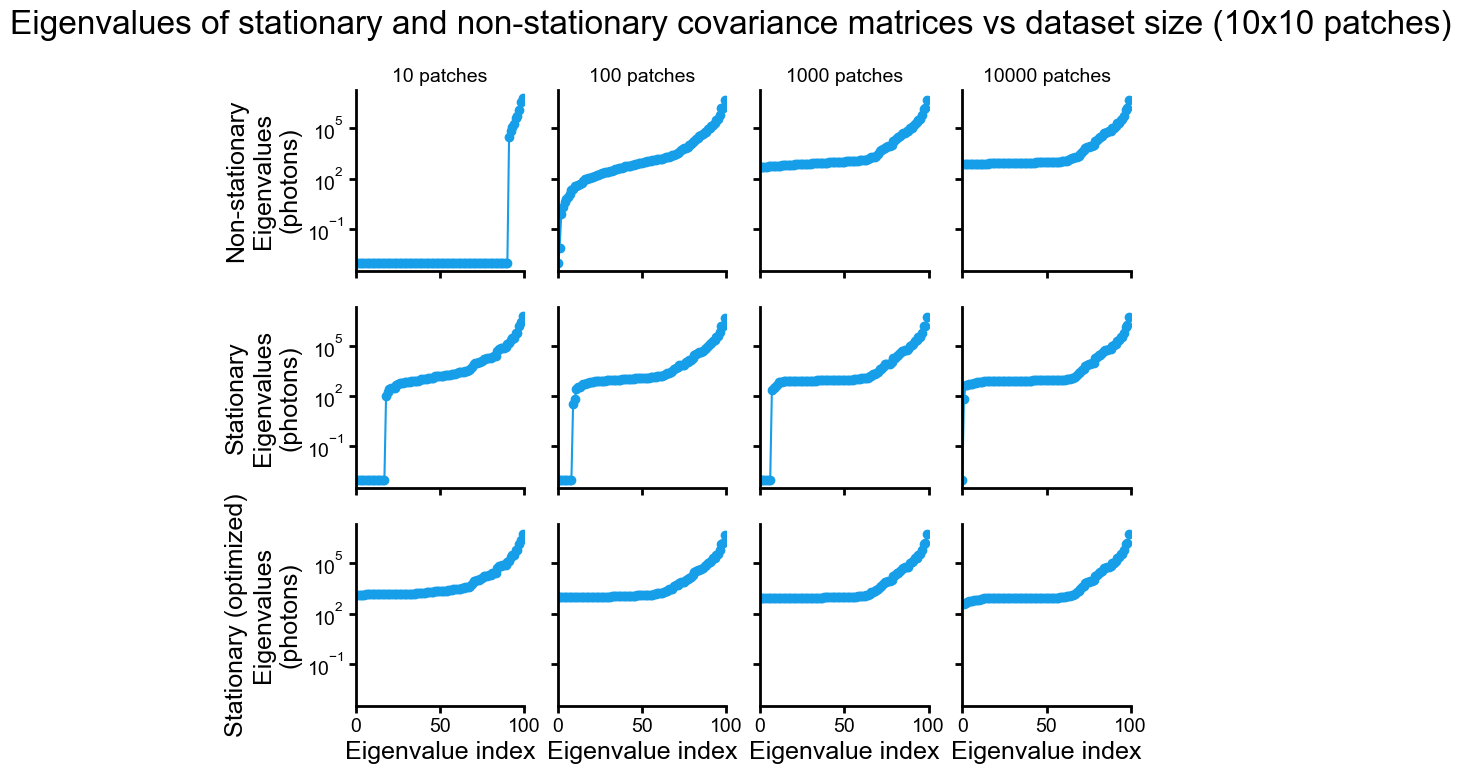

In [12]:
# num_patches_to_show = num_patches_to_use[::2]
num_patches_to_show = num_patches_to_use
num_to_show = num_patches_to_show.shape[0]

fig, ax = plt.subplots(3, num_to_show, figsize=(num_to_show * 2.5, 8), sharex=True, sharey=True)

for i, n_patches in enumerate(num_patches_to_show):
    eigs = np.linalg.eigvalsh(cov_mats[n_patches][0])
    eigs_stationary = np.linalg.eigvalsh(cov_mats_stationary[n_patches][0])
    eigs_stationary_optimized = np.linalg.eigvalsh(cov_mats_stationary_optimized[n_patches][0])
    ax[0, i].semilogy(eigs, '-o')
    ax[1, i].semilogy(eigs_stationary, '-o')
    ax[2, i].semilogy(eigs_stationary_optimized, '-o')
    clear_spines(ax[0, i])
    clear_spines(ax[1, i])
    clear_spines(ax[2, i])
    

    ax[0, i].set_title(f'{n_patches} patches')
    if i == 0:
        ax[0, i].set_ylabel('Non-stationary\nEigenvalues\n(photons)')
        ax[1, i].set_ylabel('Stationary\nEigenvalues\n(photons)')
        ax[2, i].set_ylabel('Stationary (optimized)\nEigenvalues\n(photons)')
    ax[-1, i].set(xlabel='Eigenvalue index', xlim=[0, len(eigs)])


fig.suptitle('Eigenvalues of stationary and non-stationary covariance matrices vs dataset size ({}x{} patches)'.format(patch_size, patch_size))
fig.savefig('/home/hpinkard_waller/figures/mi_estimation/stationary_vs_full_cov_fits.pdf', transparent=True)
